In [1]:
import pandas as pd
import numpy as np
import pyrebase
import sklearn
import re
import urllib.request
import requests
import math
from bs4 import BeautifulSoup
from datetime import datetime
from textblob import TextBlob, Word

In [2]:
#Extracts the query from the Google URL
def getQueryFromURL(googleurl):
    startIndex = googleurl.find('=')
    endIndex = googleurl.find('&')
    if endIndex==-1:
        return re.sub("\+", " ", googleurl[startIndex+1:])
    else:
        return re.sub("\+", " ", googleurl[startIndex+1: endIndex])
    
    
def get_query_autocomplete(googleurl):
    startIndex = googleurl.find('=')
    endIndex = googleurl.find('&')
    queryString = googleurl[startIndex+1: endIndex] if endIndex!=-1 else googleurl[startIndex+1:]
    target_url = 'https://www.google.com/complete/search?q=' + queryString+'+&pq='+queryString+'&client=chrome'
    ##Naive, assuming search query has no brackets
    autocompletesuggestions=''
    for line in urllib.request.urlopen(target_url):
        googleautosugg=line.decode('utf-8')
        startBracket = googleautosugg.index('[', 1)
        endBracket = googleautosugg.index(']', 1)
        autocompletesuggestions = googleautosugg[startBracket+1: endBracket]
    autocompletesuggestions.replace('"', "" )
    return autocompletesuggestions.split(',')

def create_url_from_text(queryUrlString):
    url = 'https://www.google.com/search?q=' +queryUrlString
    return url

def get_site_article(beautifulSoupObj):
    texts = set()
    for link in beautifulSoupObj.find_all('p'):
        texts.add(link.get_text())
    return texts

def scrape_website(url):
    req = requests.get(url)
    soup = BeautifulSoup(req.text, "html.parser")
    return soup

def setToString(set):
    return '; '.join(set)

def getNParticle(websitedom):
    paragraphs = get_site_article(websitedom)
    paragraphString = setToString(paragraphs)
    blob = TextBlob(paragraphString)
    phrases = cleanPhrases(blob.noun_phrases)
    frequency = {}
    # iterating over the list
    for item in phrases:
        # checking the element in dictionary
        if item == '':
            continue
        if item in frequency:
            # incrementing the count
            frequency[item] += 1
        else:
            # initializing the count
            frequency[item] = 1
    return dict(sorted(frequency.items(), key=lambda item: item[1], reverse=True))

def cleanPhrases(phrases):
#     for count, phrase in enumerate(phrases):
#         phrases[count] = Word(re.sub("[^a-zA-Z ]+", "", phrase).strip())
    return phrases

client_id = "3074457360917723621"
client_id2="3074457364681072467"
pilotBoards=['o9J_l0_9Oa8=', #AH
             'o9J_l1daiMk=',#GH
             'o9J_l1PIrDQ=', #KL
             'o9J_l2KryjI=', #SZ
             'o9J_l3LlFIA=',
             'o9J_l350Img=',
             'o9J_lzKK_yc=',
             'o9J_luPdtDQ='
            ]

In [3]:
boardInfo=pd.read_csv('boardInfo.csv')
boardInfo=boardInfo.set_index('boardId')
boardInfo=boardInfo.drop(['o9J_lyYiALg=','o9J_lwrV0Y8=', 'o9J_lwrV0RU=', 'o9J_lwrV0c8=', 'o9J_luPdtDQ='])
sidebarBoards=boardInfo[boardInfo['studyType']=='Sidebar']
onboardBoards=boardInfo[boardInfo['studyType']=='On Board']
sidebarBoards

,studyType,topicTask
boardId,,
o9J_lth9DEA=,Sidebar,Space Travel
o9J_lthxoK8=,Sidebar,COVID-19
o9J_lwMyp0I=,Sidebar,COVID-19
o9J_lwT45UE=,Sidebar,COVID-19
o9J_lwTEkh4=,Sidebar,COVID-19
o9J_lwTEnZk=,Sidebar,COVID-19
o9J_lwTHmNo=,Sidebar,COVID-19
o9J_lwTHmtQ=,Sidebar,Space Travel
o9J_lwhnitY=,Sidebar,COVID-19


In [4]:
suggestionCircleClicked_dict=pd.read_csv('suggCircClicked.csv')
suggestionCircleClicked_dict

,o9J_l3LlFIA=,o9J_lth3zkI=,o9J_lthisSs=,o9J_lthxoK8=,o9J_lthxoSw=,o9J_luPdtDQ=,o9J_lwT0kWk=,o9J_lwT45Gc=,o9J_lwTEnSI=,o9J_lwhnitY=,...,o9J_lwtLWq0=,o9J_lwtLZY8=,o9J_lx2--OQ=,o9J_lxPFjOs=,o9J_lxTWUZI=,o9J_ly0SnuI=,o9J_lyGIeLY=,o9J_lyYiALM=,o9J_lzKK_yc=,o9J_lzYurAk=
0,2021-09-06T05:32:37.811671,2021-09-29T21:18:45.969152,2021-09-29T01:51:59.458002,2021-09-30T00:30:10.308079,2021-09-30T01:21:10.844242,2021-09-27T20:48:39.076136,2021-09-17T19:54:25.164725,2021-09-19T18:57:56.388663,2021-09-20T22:12:49.301259,2021-09-14T22:22:28.479815,...,2021-09-16T16:10:37.446423,2021-09-15T19:46:40.357202,2021-09-13T19:21:07.409868,2021-09-13T22:35:24.822507,2021-09-14T18:35:59.152866,2021-09-06T21:31:53.929005,2021-09-07T19:38:13.633187,2021-09-13T16:45:39.070851,2021-09-01T16:15:02.298860,2021-09-03T19:02:11.951766
1,2021-09-06T05:32:53.289714,2021-09-29T21:19:24.902341,2021-09-29T01:51:59.786104,NaN,2021-09-30T01:22:56.818459,2021-09-27T20:59:20.722169,2021-09-17T20:24:03.868339,2021-09-19T18:58:05.109626,2021-09-20T22:12:57.055382,2021-09-14T22:22:51.576317,...,2021-09-16T16:10:49.977227,2021-09-15T19:54:09.495736,2021-09-13T19:21:19.728851,2021-09-13T22:35:45.090042,2021-09-14T18:55:31.076087,2021-09-06T21:32:19.249166,2021-09-07T19:45:24.133647,2021-09-13T16:46:28.735344,2021-09-01T16:18:48.059334,2021-09-03T19:03:04.606178
2,2021-09-06T05:45:20.063838,2021-09-29T21:19:35.624034,2021-09-29T01:51:52.174880,NaN,2021-09-30T01:23:16.372376,NaN,2021-09-17T20:24:09.883425,2021-09-19T18:58:13.697926,2021-09-20T22:13:10.726345,NaN,...,2021-09-16T16:11:01.348810,2021-09-15T19:47:23.174137,2021-09-13T19:27:02.696450,2021-09-13T22:36:29.374655,2021-09-14T18:37:48.505887,2021-09-06T21:32:30.409512,2021-09-07T20:12:27.818038,2021-09-13T17:04:35.732466,2021-09-01T16:14:49.810638,2021-09-03T19:32:29.347889
3,2021-09-06T05:45:47.781514,2021-09-29T21:21:24.652713,NaN,NaN,2021-09-30T01:33:43.428568,NaN,2021-09-17T19:46:03.675895,2021-09-19T19:04:05.851793,2021-09-20T22:13:14.957240,NaN,...,2021-09-16T16:18:12.880288,2021-09-15T19:47:30.035405,2021-09-13T19:20:57.434521,2021-09-13T22:37:34.105670,2021-09-14T18:42:10.650677,2021-09-06T21:14:50.437901,2021-09-07T20:07:28.554210,2021-09-13T16:27:28.073845,2021-09-01T16:18:06.839022,2021-09-03T19:32:36.149804
4,2021-09-06T05:46:06.487105,2021-09-29T21:38:24.087582,NaN,NaN,2021-09-30T01:34:01.021337,NaN,2021-09-17T19:47:02.390048,2021-09-19T19:17:39.367505,2021-09-20T22:46:23.228461,NaN,...,2021-09-16T16:18:33.527968,2021-09-15T19:48:23.495304,2021-09-13T19:32:56.911230,2021-09-13T22:39:31.234650,2021-09-14T18:48:03.328277,2021-09-06T21:23:42.289638,NaN,2021-09-13T17:04:22.297555,2021-09-01T16:14:44.474984,2021-09-03T19:32:52.167853
5,2021-09-06T05:46:23.973338,2021-09-29T21:43:31.046884,NaN,NaN,2021-09-30T02:13:05.526204,NaN,2021-09-17T19:54:05.186198,2021-09-19T19:19:59.844428,2021-09-20T22:19:26.994694,NaN,...,2021-09-16T16:18:58.067952,2021-09-15T19:48:31.483914,2021-09-13T19:28:44.886968,2021-09-13T22:44:52.890950,2021-09-14T18:50:01.322500,2021-09-06T21:31:44.780422,NaN,2021-09-13T16:27:35.530981,2021-09-01T16:19:32.882949,2021-09-03T19:01:49.283553
6,2021-09-06T05:53:51.586293,2021-09-29T21:46:09.094553,NaN,NaN,2021-09-30T02:13:28.903336,NaN,2021-09-17T19:55:12.979441,2021-09-19T19:21:03.811360,2021-09-20T22:24:15.166825,NaN,...,2021-09-16T16:19:32.308172,2021-09-15T19:48:45.055618,2021-09-13T19:39:10.048837,2021-09-13T22:48:37.139085,2021-09-14T18:50:06.737993,2021-09-06T21:38:53.647301,NaN,2021-09-13T17:04:25.127694,2021-09-01T16:30:42.972385,2021-09-03T19:03:00.427436
7,2021-09-06T06:02:28.262458,2021-09-29T21:39:24.608333,NaN,NaN,2021-09-30T02:13:50.098427,NaN,2021-09-17T19:57:33.060033,2021-09-19T19:22:08.483866,2021-09-20T22:24:06.285650,NaN,...,2021-09-16T16:32:17.047888,2021-09-15T19:53:55.809806,2021-09-13T19:44:11.022092,2021-09-13T23:02:44.760798,2021-09-14T18:50:09.671055,2021-09-06T21:38:50.184688,NaN,2021-09-13T16:41:39.184054,NaN,2021-09-03T19:03:02.449269
8,2021-09-06T05:32:43.720458,2021-

In [5]:
sidebarOpened_dict=pd.read_csv('sidebarOpened.csv')
sidebarOpened_dict['timestamp']= pd.to_datetime(sidebarOpened_dict['timestamp'])
sidebarOpened_dict

,boardId,timestamp
0,o9J_l0_9Oa8=,2021-09-01 16:08:38.225391
1,o9J_l2KryjI=,2021-09-13 21:16:16.841710
2,o9J_l350Img=,2021-08-30 21:35:27.007326
3,o9J_l3LlFIA=,2021-09-06 06:17:10.732652
4,o9J_lth9DEA=,2021-09-30 03:07:35.535670
5,o9J_lthxoK8=,2021-09-30 01:01:00.444261
6,o9J_lwMyp0I=,2021-09-17 17:09:10.708716
7,o9J_lwT45UE=,2021-09-20 19:15:29.313973
8,o9J_lwTEkh4=,2021-09-21 04:08:02.590026
9,o9J_lwTEnZk=,2021-09-21 03:14:14.089902


In [6]:
browser_df_joined =pd.read_csv('query_df.csv')
browser_df_joined['timestamp']= pd.to_datetime(browser_df_joined['timestamp'])
browser_df_joined[browser_df_joined['boardId']=='o9J_lthxoSw=']

,boardId,timestamp,query,autocomplete,people_also_ask,related_searches,webpagesVisited,clickedFromMiro,studyType,topicTask
26,o9J_lthxoSw=,2021-09-30 01:18:25.287663,environmental impacts of covid 19,"['""environmental impacts of covid 19 pandemic""...",['What are some long term effects of COVID-19?...,['positive and negative impact of covid-19 on ...,1,0,On Board,COVID-19
27,o9J_lthxoSw=,2021-09-30 01:19:09.147357,environmental impacts of covid 19,"['""environmental impacts of covid 19 pandemic""...",['What are some long term effects of COVID-19?...,['positive and negative impact of covid-19 on ...,4,0,On Board,COVID-19
28,o9J_lthxoSw=,2021-09-30 01:21:16.400895,Tourism Environmental Impacts of COVID-19,"['""tourism environmental impact""', '""tourism i...",['How has the COVID-19 pandemic impacted the e...,['environmental impact of covid-19 on tourism ...,4,1,On Board,COVID-19
29,o9J_lthxoSw=,2021-09-30 01:29:41.138431,Air pollution Pollution,"['""air pollution pollution essay in urdu""', '""...","['What is air pollution and its effects?', 'Wh...","['Effects of air pollution', 'Effects of air p...",0,1,On Board,COVID-19
30,o9J_lthxoSw=,2021-09-30 01:29:53.484752,Air pollution Pollution environmental effects ...,"['""air pollution changes due to covid 19""', '""...",NaN,NaN,1,0,On Board,COVID-19
31,o9J_lthxoSw=,2021-09-30 01:30:02.559217,Air pollution Pollution environmental effects ...,"['""air pollution changes due to covid 19""', '""...",NaN,NaN,0,0,On Board,COVID-19
32,o9J_lthxoSw=,2021-09-30 01:30:07.087119,Air pollution environmental effects of covid19,"['""air pollution changes due to covid 19""', '""...",NaN,NaN,2,0,On Board,COVID-19
33,o9J_lthxoSw=,2021-09-30 01:57:09.522793,Tourism Environmental Impacts of COVID-19,"['""tourism environmental impact""', '""tourism i...",NaN,NaN,2,1,On Board,COVID-19
34,o9J_lthxoSw=,2021-09-30 01:59:31.166648,Invasive alien species Wildlife,"['""invasive alien animal species""', '""what is ...",['How do invasive alien species affect biodive...,"['Invasive species examples', 'Invasive alien ...",0,1,On Board,COVID-19
35,o9J_lthxoSw=,2021-09-30 02:01:57.468579,Heritage conservation Tourism,"['""heritage conservation and tourism""']",['Why is heritage conservation important to to...,['Negative impact of tourism on historical sit...,1,1,On Board,COVID-19


In [7]:
suggestion_df_joined = pd.read_csv('suggestion_df.csv', dtype={'parentIdB': str, 'parentIdA':str})
suggestion_df_joined['timestamp']= pd.to_datetime(suggestion_df_joined['timestamp'])
suggestion_df_joined['lastUpdated']= pd.to_datetime(suggestion_df_joined['lastUpdated'])
suggestion_df_joined['parentIdB']=suggestion_df_joined['parentIdB'].fillna(0.0).astype('int64')
suggestion_df_joined['parentIdA']=suggestion_df_joined['parentIdA'].astype('string')
suggestion_df_joined['parentIdB']=suggestion_df_joined['parentIdB'].astype('string')
suggestion_df_joined[suggestion_df_joined['boardId']=='o9J_lthxoSw=']

,boardId,suggId,timestamp,suggestionText,type,status,lastUpdated,parentIdA,parentIdB,grouping,studyType,topicTask,opened,suggestionsQueried
26,o9J_lthxoSw=,-MkoHY4DZgeNQOCHu5EJ,2021-09-30 01:20:49.954782,Tourism,Note,4,2021-09-30 02:21:03.586413,3074457364776794012,0,Note,On Board,COVID-19,1,1
27,o9J_lthxoSw=,-MkoHY8549mp37l_YUhD,2021-09-30 01:20:49.954782,Biodiversity,Note,4,2021-09-30 02:21:03.717494,3074457364776794012,0,Note,On Board,COVID-19,1,1
28,o9J_lthxoSw=,-MkoHYC1UrgZbALEpW11,2021-09-30 01:20:49.954782,Water pollution,Note,2,2021-09-30 02:21:03.777324,3074457364776794012,0,Note,On Board,COVID-19,0,0
29,o9J_lthxoSw=,-MkoIP8lsGVzCK7a2wtG,2021-09-30 01:24:35.507522,Air pollution,Note,4,2021-09-30 02:13:09.331556,3074457364851934843,0,Note,On Board,COVID-19,1,1
30,o9J_lthxoSw=,-MkoIPCECY6xUazsKzXA,2021-09-30 01:24:35.507522,Noise pollution,Note,2,2021-09-30 02:13:09.333218,3074457364851934843,0,Note,On Board,COVID-19,0,0
31,o9J_lthxoSw=,-MkoIPFZwTtefYRaMeit,2021-09-30 01:24:35.507522,Plastic pollution,Note,2,2021-09-30 02:13:09.337591,3074457364851934843,0,Note,On Board,COVID-19,0,0
32,o9J_lthxoSw=,-MkoIXI-zkZK75bgpPO-,2021-09-30 01:25:08.865230,Invasive alien species,Note,4,2021-09-30 02:13:03.066452,3074457364851934753,0,Note,On Board,COVID-19,1,1
33,o9J_lthxoSw=,-MkoIXL_mBcCd0jyWmOd,2021-09-30 01:25:08.865230,Reduced fishing,Note,2,2021-09-30 02:13:03.196736,3074457364851934753,0,Note,On Board,COVID-19,0,0
34,o9J_lthxoSw=,-MkoIXPHAopzk5q9u-ob,2021-09-30 01:25:08.865230,Illegal killing/poaching of wildlife,Note,5,2021-09-30 02:01:15.798053,3074457364851934753,0,Note,On Board,COVID-19,0,0
35,o9J_lthxoSw=,-MkoIliL3vAzQbsp78sA,2021-09-30 01:26:12.060312,Decreased transport,Line,5,2021-09-30 02:05:59.163647,3074457364851934665,3074457364851934753,Line,On Board,COVID-19,0,0


## Aggregation calculations

In [8]:
suggestions_textcnt=suggestion_df_joined[['boardId', 'suggestionText']].groupby(['boardId']).count().rename(columns={"suggestionText": "suggestionsOffered"})
suggestions_opened=suggestion_df_joined[['boardId', 'opened']].groupby(['boardId'])['opened'].sum()
suggestions_suggestionText=suggestion_df_joined[['boardId', 'suggestionsQueried']].groupby(['boardId'])['suggestionsQueried'].sum()
suggestions_agg=suggestions_textcnt.join(suggestions_opened, how='inner')
suggestions_agg=suggestions_agg.join(suggestions_suggestionText, how='inner')
suggestions_agg=suggestions_agg.join(boardInfo, how='inner')
suggestions_agg

,suggestionsOffered,opened,suggestionsQueried,studyType,topicTask
boardId,,,,,
o9J_lth3zkI=,13,7,7,On Board,Space Travel
o9J_lth9DEA=,6,6,0,Sidebar,Space Travel
o9J_lthxoK8=,7,7,1,Sidebar,COVID-19
o9J_lthxoSw=,14,6,6,On Board,COVID-19
o9J_lwMyp0I=,26,26,5,Sidebar,COVID-19
o9J_lwT0kWk=,22,5,5,On Board,Space Travel
o9J_lwT45Gc=,16,14,14,On Board,COVID-19
o9J_lwT45UE=,12,12,3,Sidebar,COVID-19
o9J_lwTEkh4=,11,5,5,Sidebar,COVID-19


In [9]:
browser_df_MiroSuggestions = browser_df_joined[browser_df_joined['clickedFromMiro']==1]
browser_MiroQuery = browser_df_MiroSuggestions[['boardId', 'query']].groupby(['boardId']).nunique().rename(columns={'query': 'UniqueMiroQueriesIssued'})
browser_allQuery = browser_df_joined[['boardId', 'query']].groupby(['boardId']).nunique().rename(columns={'query': 'UniqueQueriesIssued'})
browser_webpages = browser_df_joined[['boardId', 'webpagesVisited']].groupby(['boardId'])['webpagesVisited'].sum()
browser_cnt = browser_df_joined[['boardId','timestamp']].groupby(['boardId']).count().rename(columns={'timestamp': 'queriesIssued'})
browser_agg=browser_cnt.join(browser_allQuery, how='inner')
browser_agg=browser_agg.join(browser_MiroQuery, how='inner')
browser_agg=browser_agg.join(browser_webpages, how='inner')
browser_agg=browser_agg.join(boardInfo, how='inner')
browser_agg

,queriesIssued,UniqueQueriesIssued,UniqueMiroQueriesIssued,webpagesVisited,studyType,topicTask
boardId,,,,,,
o9J_lth3zkI=,16,12,9,19,On Board,Space Travel
o9J_lthxoK8=,8,4,1,9,Sidebar,COVID-19
o9J_lthxoSw=,20,12,6,20,On Board,COVID-19
o9J_lwMyp0I=,6,6,5,22,Sidebar,COVID-19
o9J_lwT0kWk=,6,6,4,7,On Board,Space Travel
o9J_lwT45Gc=,24,18,14,25,On Board,COVID-19
o9J_lwT45UE=,8,6,3,12,Sidebar,COVID-19
o9J_lwTEkh4=,5,5,5,5,Sidebar,COVID-19
o9J_lwTEnSI=,23,18,13,34,On Board,Space Travel


### Percentage of suggestions queried by board

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors
import numpy as np
from datetime import datetime
from matplotlib import collections as mc
from datetime import timedelta
from scipy import stats
aggTotalBoard = boardInfo
aggTotalBoard

,studyType,topicTask
boardId,,
o9J_lth3zkI=,On Board,Space Travel
o9J_lth9DEA=,Sidebar,Space Travel
o9J_lthxoK8=,Sidebar,COVID-19
o9J_lthxoSw=,On Board,COVID-19
o9J_lwMyp0I=,Sidebar,COVID-19
o9J_lwT0kWk=,On Board,Space Travel
o9J_lwT45Gc=,On Board,COVID-19
o9J_lwT45UE=,Sidebar,COVID-19
o9J_lwTEkh4=,Sidebar,COVID-19


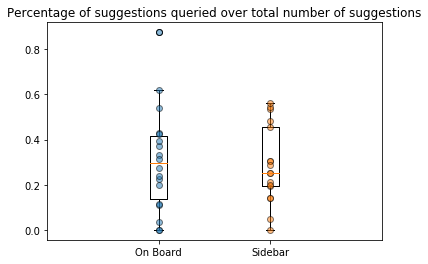

In [11]:
suggestion_df_joined=suggestion_df_joined.astype({'opened': 'float64', 'suggestionsQueried': 'float64'})
suggestions_textcnt=suggestion_df_joined[['boardId', 'suggestionText']].groupby(['boardId']).count().rename(columns={"suggestionText": "suggestionsOffered"})
suggestionsQueried_onboard=suggestion_df_joined[suggestion_df_joined['studyType']=='On Board'].pivot_table(index=['studyType','boardId'], aggfunc='sum')
suggestionsQueried_onboard=suggestions_textcnt.join(suggestionsQueried_onboard, how='inner')
suggestionsQueried_sidebar=suggestion_df_joined[suggestion_df_joined['studyType']=='Sidebar'].pivot_table(index=['studyType','boardId'], aggfunc='sum')
suggestionsQueried_sidebar=suggestions_textcnt.join(suggestionsQueried_sidebar, how='inner')
f, ax = plt.subplots()
ax.boxplot(suggestionsQueried_onboard['suggestionsQueried']/suggestionsQueried_onboard['suggestionsOffered'],positions=[1])
ax.boxplot(suggestionsQueried_sidebar['suggestionsQueried']/suggestionsQueried_sidebar['suggestionsOffered'],positions=[2])
ax.plot([1 for x in range(len(suggestionsQueried_onboard['suggestionsQueried']))], suggestionsQueried_onboard['suggestionsQueried']/suggestionsQueried_onboard['suggestionsOffered'], 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2 for x in range(len(suggestionsQueried_sidebar['suggestionsQueried']))], suggestionsQueried_sidebar['suggestionsQueried']/suggestionsQueried_sidebar['suggestionsOffered'], 'o', markeredgecolor='k', alpha=0.5)
ax.set_title('Percentage of suggestions queried over total number of suggestions')
plt.xlim([0, 3])
ax.set_xticks([1, 2])
ax.set_xticklabels(['On Board', 'Sidebar'])
plt.savefig(r'C://Users/sheld/ReimaginedSearch/visualizations/suggestionsQueried.png')
aggTotalBoard=aggTotalBoard.join(suggestions_textcnt)
aggTotalBoard=aggTotalBoard.join(suggestion_df_joined.pivot_table(index=['studyType','boardId'], aggfunc='sum')['suggestionsQueried'])

In [12]:

aggTotalBoard

studyType     topicTask  suggestionsOffered  \
studyType boardId                                                    
On Board  o9J_lth3zkI=  On Board  Space Travel                  13   
          o9J_lthxoSw=  On Board      COVID-19                  14   
          o9J_lwT0kWk=  On Board  Space Travel                  22   
          o9J_lwT45Gc=  On Board      COVID-19                  16   
          o9J_lwTEnSI=  On Board  Space Travel                  21   
          o9J_lwi6_1c=  On Board      COVID-19                  27   
          o9J_lwj9wsM=  On Board      COVID-19                  27   
          o9J_lwt44k0=  On Board  Space Travel                  35   
          o9J_lwtLWq0=  On Board  Space Travel                  26   
          o9J_lwtLZY8=  On Board      COVID-19                  27   
          o9J_lx2--OQ=  On Board  Space Travel                  25   
          o9J_lxPFjOs=  On Board  Space Travel                  28   
          o9J_lxTWUZI=  On Board  Space Travel                  44   
          o9J_ly0SnuI=  On Board      COVID-19                  24   
          o9J_lyGIeLY=  On Board      COVID-19                  23   
          o9J_lyYiALM=  On Board  Space Travel                  25   
          o9J_lzYurAk=  On Board      COVID-19                  19   
Sidebar   o9J_lth9DEA=   Sidebar  Space Travel                   6   
          o9J_lthxoK8=   Sidebar      COVID-19                   7   
          o9J_lwMyp0I=   Sidebar      COVID-19                  26   
          o9J_lwT45UE=   Sidebar      COVID-19                  12   
          o9J_lwTEkh4=   Sidebar      COVID-19                  11   
          o9J_lwTEnZk=   Sidebar      COVID-19                  20   
          o9J_lwTHmNo=   Sidebar      COVID-19                  15   
          o9J_lwTHmtQ=   Sidebar  Space Travel                  14   
          o9J_lwhnitY=   Sidebar      COVID-19                  25   
          o9J_lwtLWiA=   Sidebar  Space Travel                  23   
          o9J_lxP9EsE=   Sidebar  Space Travel                  21   
          o9J_ly0SnkM=   Sidebar      COVID-19                  22   
          o9J_ly0Snnk=   Sidebar  Space Travel                  23   
          o9J_lyGIfks=   Sidebar      COVID-19                  19   
          o9J_lyGIfzA=   Sidebar  Space Travel                  15   
          o9J_lyYiAJ0=   Sidebar      COVID-19                  16   
          o9J_lzYgHyw=   Sidebar  Space Travel                  21   

                        suggestionsQueried  
studyType boardId                           
On Board  o9J_lth3zkI=                 7.0  
          o9J_lthxoSw=                 6.0  
          o9J_lwT0kWk=                 5.0  
          o9J_lwT45Gc=                14.0  
          o9J_lwTEnSI=                13.0  
          o9J_lwi6_1c=                10.0  
          o9J_lwj9wsM=                 3.0  
          o9J_lwt44k0=                 4.0  
          o9J_lwtLWq0=                11.0  
          o9J_lwtLZY8=                 1.0  
          o9J_lx2--OQ=                 5.0  
          o9J_lxPFjOs=                11.0  
          o9J_lxTWUZI=                12.0  
          o9J_ly0SnuI=                 8.0  
          o9J_lyGIeLY=                 0.0  
          o9J_lyYiALM=                 6.0  
          o9J_lzYurAk=                 6.0  
Sidebar   o9J_lth9DEA=                 0.0  
          o9J_lthxoK8=                 1.0  
          o9J_lwMyp0I=                 5.0  
          o9J_lwT45UE=                 3.0  
          o9J_lwTEkh4=                 5.0  
          o9J_lwTEnZk=                 5.0  
          o9J_lwTHmNo=                 8.0  
          o9J_lwTHmtQ=                 2.0  
          o9J_lwhnitY=                12.0  
          o9J_lwtLWiA=                 7.0  
          o9J_lxP9EsE=                 1.0  
          o9J_ly0SnkM=                12.0  
          o9J_ly0Snnk=                 7.0  
          o9J_lyGIfks=                 4.0  
          o9J_lyG

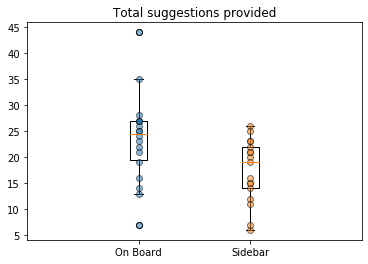

In [13]:
f, ax = plt.subplots()
ax.boxplot(suggestionsQueried_onboard['suggestionsOffered'],positions=[1])
ax.boxplot(suggestionsQueried_sidebar['suggestionsOffered'],positions=[2])
ax.plot([1 for x in range(len(suggestionsQueried_onboard['suggestionsOffered']))], suggestionsQueried_onboard['suggestionsOffered'], 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2 for x in range(len(suggestionsQueried_sidebar['suggestionsOffered']))], suggestionsQueried_sidebar['suggestionsOffered'], 'o', markeredgecolor='k', alpha=0.5)
ax.set_title('Total suggestions provided')
plt.xlim([0, 3])
ax.set_xticks([1, 2])
ax.set_xticklabels(['On Board', 'Sidebar'])
plt.show()
#suggestionsQueried_onboard

#### Testing for normality

In [14]:
suggProp_Sidebar=suggestionsQueried_sidebar['suggestionsOffered']/suggestionsQueried_sidebar['suggestionsOffered']
suggProp_Onboard=suggestionsQueried_onboard['suggestionsQueried']/suggestionsQueried_onboard['suggestionsOffered']
print("Sample size:")
print("On Board: " + str(len(suggestionsQueried_onboard['suggestionsQueried'].dropna())))
print("Sidebar: " + str(len(suggestionsQueried_sidebar['suggestionsQueried'].dropna())))
print('Means:')
print('On Board: ' +str(suggProp_Onboard.mean()) )
print('Sidebar: ' +str(suggProp_Sidebar.mean()) )
print('Variance:')
print('On Board: ' +str(suggestionsQueried_onboard['suggestionsQueried'].var()) )
print('Sidebar: ' +str(suggestionsQueried_sidebar['suggestionsQueried'].var()) )
print(stats.shapiro(suggestionsQueried_onboard['suggestionsQueried'].dropna()))
print(stats.shapiro(suggestionsQueried_sidebar['suggestionsQueried'].dropna()))


Sample size:
On Board: 18
Sidebar: 17
Means:
On Board: 0.30549676065757936
Sidebar: 1.0
Variance:
On Board: 18.88888888888889
Sidebar: 12.84558823529412
ShapiroResult(statistic=0.9545658826828003, pvalue=0.5010362267494202)
ShapiroResult(statistic=0.9515278339385986, pvalue=0.48112958669662476)


#### Testing for Homoschedasticity


In [15]:
print(stats.bartlett(suggestionsQueried_onboard['suggestionsQueried'].dropna(), suggestionsQueried_sidebar['suggestionsQueried'].dropna()))
print(stats.levene(suggestionsQueried_onboard['suggestionsQueried'].dropna(), suggestionsQueried_sidebar['suggestionsQueried'].dropna()))

BartlettResult(statistic=0.5887264752755664, pvalue=0.4429120057815811)
LeveneResult(statistic=0.6818629885760139, pvalue=0.4148760342498554)


#### Using Contingency table 

In [16]:
contingencytable = np.array([[suggestionsQueried_onboard['suggestionsQueried'].sum(), suggestionsQueried_sidebar['suggestionsQueried'].sum()],
                   [suggestionsQueried_onboard['suggestionsOffered'].sum(), suggestionsQueried_sidebar['suggestionsOffered'].sum()]])

pvalue=stats.chi2_contingency(contingencytable)[1]
pvalue

0.7992554129104044

### Percentage of queries issued from Miro over total number of queries

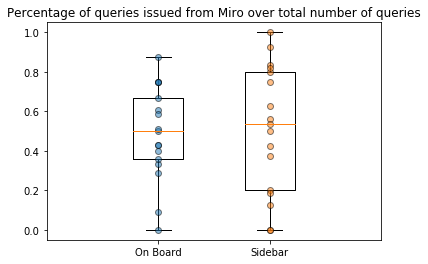

In [17]:
browser_df_joined['time_diff'] = browser_df_joined.groupby(['boardId'])['timestamp'].diff()
browser_pivottable=browser_df_joined.pivot_table(index=['boardId'],columns='studyType')
browser_pivottable_sum=browser_df_joined.pivot_table(index=['boardId'],columns='studyType', aggfunc='sum')
browser_pivottable_count=browser_df_joined[['clickedFromMiro', 'webpagesVisited', 'boardId', 'studyType']].pivot_table(index=['boardId'],columns='studyType', aggfunc='count')
browser_percentage = browser_pivottable_sum/browser_pivottable_count
queries_notfrommiro =browser_pivottable_count-browser_pivottable_sum
f, ax = plt.subplots()
ax.boxplot(browser_percentage['clickedFromMiro']['On Board'].dropna(),positions=[1/3])
ax.boxplot(browser_percentage['clickedFromMiro']['Sidebar'].dropna(),positions=[2/3])
ax.plot([1/3 for x in range(len(browser_percentage['clickedFromMiro']['On Board']))], browser_percentage['clickedFromMiro']['On Board'], 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2/3 for x in range(len(browser_percentage['clickedFromMiro']['Sidebar']))], browser_percentage['clickedFromMiro']['Sidebar'], 'o', markeredgecolor='k', alpha=0.5)
ax.set_title('Percentage of queries issued from Miro over total number of queries')
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
plt.savefig(r'C://Users/sheld/ReimaginedSearch/visualizations/MiroQueries.png')

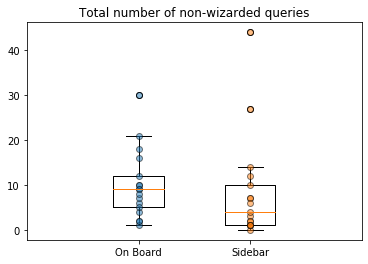

In [18]:
f, ax = plt.subplots()
ax.boxplot(queries_notfrommiro['clickedFromMiro']['On Board'].dropna(),positions=[1/3])
ax.boxplot(queries_notfrommiro['clickedFromMiro']['Sidebar'].dropna(),positions=[2/3])
ax.plot([1/3 for x in range(len(queries_notfrommiro['clickedFromMiro']['On Board']))], queries_notfrommiro['clickedFromMiro']['On Board'], 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2/3 for x in range(len(queries_notfrommiro['clickedFromMiro']['Sidebar']))], queries_notfrommiro['clickedFromMiro']['Sidebar'], 'o', markeredgecolor='k', alpha=0.5)
ax.set_title('Total number of non-wizarded queries')
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
aggTotalBoard=aggTotalBoard.join(queries_notfrommiro['clickedFromMiro']).fillna(0)
aggTotalBoard['queriesNotFromMiro']=aggTotalBoard['On Board']+aggTotalBoard['Sidebar']
aggTotalBoard=aggTotalBoard.drop(['On Board', 'Sidebar'], axis=1)

In [19]:
aggTotalBoard

studyType     topicTask  suggestionsOffered  \
studyType boardId                                                    
On Board  o9J_lth3zkI=  On Board  Space Travel                  13   
          o9J_lthxoSw=  On Board      COVID-19                  14   
          o9J_lwT0kWk=  On Board  Space Travel                  22   
          o9J_lwT45Gc=  On Board      COVID-19                  16   
          o9J_lwTEnSI=  On Board  Space Travel                  21   
          o9J_lwi6_1c=  On Board      COVID-19                  27   
          o9J_lwj9wsM=  On Board      COVID-19                  27   
          o9J_lwt44k0=  On Board  Space Travel                  35   
          o9J_lwtLWq0=  On Board  Space Travel                  26   
          o9J_lwtLZY8=  On Board      COVID-19                  27   
          o9J_lx2--OQ=  On Board  Space Travel                  25   
          o9J_lxPFjOs=  On Board  Space Travel                  28   
          o9J_lxTWUZI=  On Board  Space Travel                  44   
          o9J_ly0SnuI=  On Board      COVID-19                  24   
          o9J_lyGIeLY=  On Board      COVID-19                  23   
          o9J_lyYiALM=  On Board  Space Travel                  25   
          o9J_lzYurAk=  On Board      COVID-19                  19   
Sidebar   o9J_lth9DEA=   Sidebar  Space Travel                   6   
          o9J_lthxoK8=   Sidebar      COVID-19                   7   
          o9J_lwMyp0I=   Sidebar      COVID-19                  26   
          o9J_lwT45UE=   Sidebar      COVID-19                  12   
          o9J_lwTEkh4=   Sidebar      COVID-19                  11   
          o9J_lwTEnZk=   Sidebar      COVID-19                  20   
          o9J_lwTHmNo=   Sidebar      COVID-19                  15   
          o9J_lwTHmtQ=   Sidebar  Space Travel                  14   
          o9J_lwhnitY=   Sidebar      COVID-19                  25   
          o9J_lwtLWiA=   Sidebar  Space Travel                  23   
          o9J_lxP9EsE=   Sidebar  Space Travel                  21   
          o9J_ly0SnkM=   Sidebar      COVID-19                  22   
          o9J_ly0Snnk=   Sidebar  Space Travel                  23   
          o9J_lyGIfks=   Sidebar      COVID-19                  19   
          o9J_lyGIfzA=   Sidebar  Space Travel                  15   
          o9J_lyYiAJ0=   Sidebar      COVID-19                  16   
          o9J_lzYgHyw=   Sidebar  Space Travel                  21   

                        suggestionsQueried  queriesNotFromMiro  
studyType boardId                                               
On Board  o9J_lth3zkI=                 7.0                 4.0  
          o9J_lthxoSw=                 6.0                12.0  
          o9J_lwT0kWk=                 5.0                 2.0  
          o9J_lwT45Gc=                14.0                 6.0  
          o9J_lwTEnSI=                13.0                 9.0  
          o9J_lwi6_1c=                10.0                 7.0  
          o9J_lwj9wsM=                 3.0                 5.0  
          o9J_lwt44k0=                 4.0                10.0  
          o9J_lwtLWq0=                11.0                30.0  
          o9J_lwtLZY8=                 1.0                10.0  
          o9J_lx2--OQ=                 5.0                18.0  
          o9J_lxPFjOs=                11.0                21.0  
          o9J_lxTWUZI=                12.0                 1.0  
          o9J_ly0SnuI=                 8.0                16.0  
          o9J_lyGIeLY=                 0.0                 9.0  
          o9J_lyYiALM=                 6.0                 2.0  
          o9J_lzYurAk=                 6.0                 8.0  
Sidebar   o9J_lth9DEA=                 0.0                 2.0  
          o9J_lthxoK8=                 1.0                 7.0  
          o9J_lwMyp0I=                 5.0                 1.0  
          o9J_lwT45UE=                 3.0                 3.0  
       

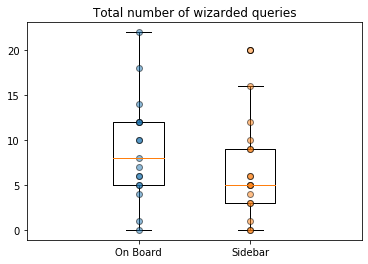

In [20]:
f, ax = plt.subplots()
ax.boxplot(browser_pivottable_sum['clickedFromMiro']['On Board'].dropna(),positions=[1/3])
ax.boxplot(browser_pivottable_sum['clickedFromMiro']['Sidebar'].dropna(),positions=[2/3])
ax.plot([1/3 for x in range(len(browser_pivottable_sum['clickedFromMiro']['On Board']))], browser_pivottable_sum['clickedFromMiro']['On Board'], 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2/3 for x in range(len(browser_pivottable_sum['clickedFromMiro']['Sidebar']))], browser_pivottable_sum['clickedFromMiro']['Sidebar'], 'o', markeredgecolor='k', alpha=0.5)
ax.set_title('Total number of wizarded queries')
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
aggTotalBoard=aggTotalBoard.join(browser_pivottable_sum['clickedFromMiro']).fillna(0)
aggTotalBoard['queriesFromMiro']=aggTotalBoard['On Board']+aggTotalBoard['Sidebar']
aggTotalBoard=aggTotalBoard.drop(['On Board', 'Sidebar'], axis=1)

In [21]:
print("Sample size:")
print("On Board: " + str(len(browser_pivottable['clickedFromMiro']['On Board'].dropna())))
print("Sidebar: " + str(len(browser_pivottable['clickedFromMiro']['Sidebar'].dropna())))
print('Means:')
print('On Board: ' +str(browser_pivottable['clickedFromMiro']['On Board'].dropna().mean()) )
print('Sidebar: ' +str(browser_pivottable['clickedFromMiro']['Sidebar'].dropna().mean()) )
print('Variance:')
print('On Board: ' +str(browser_pivottable['clickedFromMiro']['On Board'].dropna().var()) )
print('Sidebar: ' +str(browser_pivottable['clickedFromMiro']['Sidebar'].dropna().var()) )
print(stats.shapiro(browser_pivottable['clickedFromMiro']['On Board'].dropna()))
print(stats.shapiro(browser_pivottable['clickedFromMiro']['Sidebar'].dropna()))

Sample size:
On Board: 17
Sidebar: 17
Means:
On Board: 0.4896745849516114
Sidebar: 0.5091848534120125
Variance:
On Board: 0.0565930949075509
Sidebar: 0.1039973088601776
ShapiroResult(statistic=0.9676368236541748, pvalue=0.7758497595787048)
ShapiroResult(statistic=0.9456194639205933, pvalue=0.39101362228393555)


#### Testing for homoscedascity

In [22]:
print(stats.bartlett(browser_pivottable['clickedFromMiro']['On Board'].dropna(), browser_pivottable['clickedFromMiro']['Sidebar'].dropna()))
print(stats.levene(browser_pivottable['clickedFromMiro']['On Board'].dropna(), browser_pivottable['clickedFromMiro']['Sidebar'].dropna()))

BartlettResult(statistic=1.4144811666667396, pvalue=0.23431391619855566)
LeveneResult(statistic=2.0772500267402054, pvalue=0.15922421976603973)


#### Using contingency table

In [23]:
onboardMiroQueries = browser_pivottable_sum['clickedFromMiro']['On Board'].sum()
sidebarMiroQueries = browser_pivottable_sum['clickedFromMiro']['Sidebar'].sum()
totalOnBoardQueries = browser_pivottable_count['clickedFromMiro']['On Board'].sum()
totalSidebarQueries = browser_pivottable_count['clickedFromMiro']['Sidebar'].sum()
contingencytable= [[onboardMiroQueries, sidebarMiroQueries], [totalOnBoardQueries, totalSidebarQueries]]

pvalue=stats.chi2_contingency(contingencytable)[1]
pvalue

0.7525558309910223

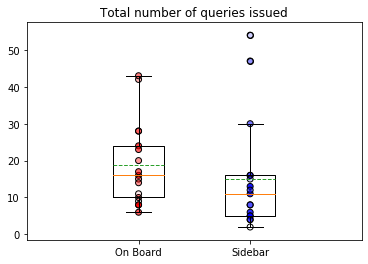

In [24]:
browser_pivottable_count
rgba_colors1 = np.zeros((17,4))
rgba_colors1[:,0] = 1.0
rgba_colors1[:, 3] = browser_percentage['clickedFromMiro']['On Board'].dropna()
rgba_colors2 = np.zeros((17,4))
rgba_colors2[:,2] = 1.0
rgba_colors2[:, 3] = browser_percentage['clickedFromMiro']['Sidebar'].dropna()
f, ax = plt.subplots()
ax.boxplot(browser_pivottable_count['clickedFromMiro']['On Board'].dropna(),positions=[1/3], meanline=True, showmeans=True)
ax.boxplot(browser_pivottable_count['clickedFromMiro']['Sidebar'].dropna(),positions=[2/3],meanline=True, showmeans=True)
ax.scatter([1/3  for x in range(len(browser_pivottable_count['clickedFromMiro']['On Board'].dropna()))], browser_pivottable_count['clickedFromMiro']['On Board'].dropna(), c=rgba_colors1, edgecolors='k')
ax.scatter([2/3 for x in range(len(browser_pivottable_count['clickedFromMiro']['Sidebar'].dropna()))], browser_pivottable_count['clickedFromMiro']['Sidebar'].dropna(), c=rgba_colors2, edgecolors='k')
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
ax.set_title('Total number of queries issued')
plt.show()

In [25]:
browser_pivottable_count
##Outliers: 
##For On board: o9J_lxPFjOs= P13
##For Sidebar: o9J_lzYgHyw=, o9J_ly0SnkM= P1, P3

clickedFromMiro         webpagesVisited        
studyType           On Board Sidebar        On Board Sidebar
boardId                                                     
o9J_lth3zkI=            16.0     NaN            16.0     NaN
o9J_lth9DEA=             NaN     2.0             NaN     2.0
o9J_lthxoK8=             NaN     8.0             NaN     8.0
o9J_lthxoSw=            20.0     NaN            20.0     NaN
o9J_lwMyp0I=             NaN     6.0             NaN     6.0
o9J_lwT0kWk=             6.0     NaN             6.0     NaN
o9J_lwT45Gc=            24.0     NaN            24.0     NaN
o9J_lwT45UE=             NaN     8.0             NaN     8.0
o9J_lwTEkh4=             NaN     5.0             NaN     5.0
o9J_lwTEnSI=            23.0     NaN            23.0     NaN
o9J_lwTEnZk=             NaN     5.0             NaN     5.0
o9J_lwTHmNo=             NaN    11.0             NaN    11.0
o9J_lwTHmtQ=             NaN     4.0             NaN     4.0
o9J_lwhnitY=             NaN    13.0             NaN    13.0
o9J_lwi6_1c=            17.0     NaN            17.0     NaN
o9J_lwj9wsM=            10.0     NaN            10.0     NaN
o9J_lwt44k0=            15.0     NaN            15.0     NaN
o9J_lwtLWiA=             NaN    16.0             NaN    16.0
o9J_lwtLWq0=            42.0     NaN            42.0     NaN
o9J_lwtLZY8=            11.0     NaN            11.0     NaN
o9J_lx2--OQ=            28.0     NaN            28.0     NaN
o9J_lxP9EsE=             NaN     4.0             NaN     4.0
o9J_lxPFjOs=            43.0     NaN            43.0     NaN
o9J_lxTWUZI=             8.0     NaN             8.0     NaN
o9J_ly0SnkM=             NaN    47.0             NaN    47.0
o9J_ly0Snnk=             NaN    12.0             NaN    12.0
o9J_ly0SnuI=            28.0     NaN            28.0     NaN
o9J_lyGIeLY=             9.0     NaN             9.0     NaN
o9J_lyGIfks=             NaN    16.0             NaN    16.0
o9J_lyGIfzA=             NaN    15.0             NaN    15.0
o9J_lyYiAJ0=             NaN    30.0             NaN    30.0
o9J_lyYiALM=             8.0     NaN             8.0     NaN
o9J_lzYgHyw=             NaN    54.0             NaN    54.0
o9J_lzYurAk=            14.0     NaN            14.0     NaN

### Total Queries Issued

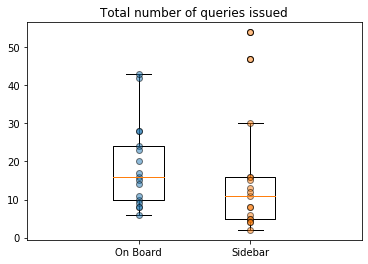

In [26]:
total_queries = browser_df_joined.pivot_table('timestamp', index=['boardId'],columns='studyType', aggfunc=len,dropna=False)
#total_queries_avg = pd.DataFrame([[total_queries['On Board'].mean(), total_queries['Sidebar'].mean()]], columns = ['On Board', 'Sidebar'], index=['Avg'])
#total_queries=total_queries.append(total_queries_avg)
total_queries.style.set_caption('Number of queries')
f, ax = plt.subplots()
ax.boxplot(total_queries['On Board'].dropna(),positions=[1/3], meanline=True)
ax.boxplot(total_queries['Sidebar'].dropna(),positions=[2/3],meanline=True)
ax.plot([1/3  for x in range(len(total_queries['On Board']))], total_queries['On Board'], 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2/3 for x in range(len(total_queries['Sidebar']))], total_queries['Sidebar'], 'o', markeredgecolor='k', alpha=0.5)
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
ax.set_title('Total number of queries issued')
plt.savefig(r'C://Users/sheld/ReimaginedSearch/visualizations/totalQueries.png')

In [27]:
print("Sample size:")
print("On Board: " + str(len(total_queries['On Board'].dropna())))
print("Sidebar: " + str(len(total_queries['Sidebar'].dropna())))
print('Means:')
print('On Board: ' +str(total_queries['On Board'].dropna().mean()) )
print('Sidebar: ' +str(total_queries['Sidebar'].dropna().mean()) )
print('Variance:')
print('On Board: ' +str(total_queries['On Board'].dropna().var()) )
print('Sidebar: ' +str(total_queries['Sidebar'].dropna().var()) )
print(stats.shapiro(total_queries['On Board'].dropna()))
print(stats.shapiro(total_queries['Sidebar'].dropna()))

Sample size:
On Board: 17
Sidebar: 17
Means:
On Board: 18.941176470588236
Sidebar: 15.058823529411764
Variance:
On Board: 126.18382352941178
Sidebar: 224.43382352941174
ShapiroResult(statistic=0.8879599571228027, pvalue=0.04288503900170326)
ShapiroResult(statistic=0.7495495080947876, pvalue=0.000446480669779703)


#### Using Mann-Whitney U Test

In [28]:
stats.mannwhitneyu(total_queries['On Board'].dropna(), total_queries['Sidebar'].dropna())

MannwhitneyuResult(statistic=95.5, pvalue=0.047156806197130405)

#### Using two sample t-test

In [29]:
stats.ttest_ind(total_queries['On Board'].dropna(), total_queries['Sidebar'].dropna())

Ttest_indResult(statistic=0.8548749461525149, pvalue=0.39897568510702974)

### Percentage of suggestions queried by type

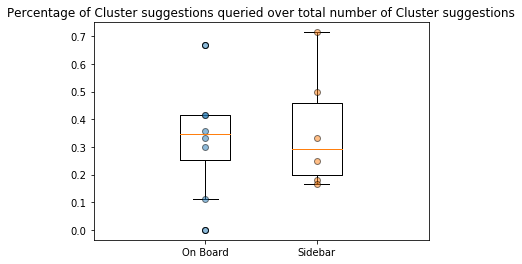

Sample size:
On Board: 8
Sidebar: 6
Means:
On Board: 0.3251984126984127
Sidebar: 0.35768398268398266
Variance:
On Board: 0.040948916603678505
Sidebar: 0.045404766589831516
ShapiroResult(statistic=0.9498643279075623, pvalue=0.7098643183708191)
ShapiroResult(statistic=0.8871282339096069, pvalue=0.30341342091560364)
BartlettResult(statistic=0.01439665779227859, pvalue=0.9044941801277404)
LeveneResult(statistic=0.06304302677962895, pvalue=0.8059972745216759)
Ttest_indResult(statistic=-0.2907349212194113, pvalue=0.7762176652386077)
MannwhitneyuResult(statistic=23.5, pvalue=0.5)


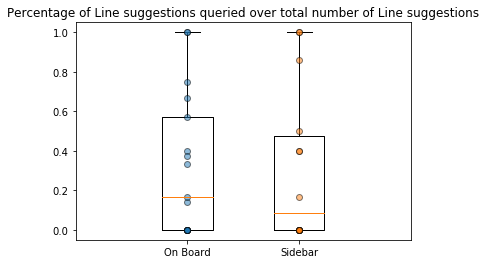

Sample size:
On Board: 17
Sidebar: 14
Means:
On Board: 0.3179971988795518
Sidebar: 0.30884353741496595
Variance:
On Board: 0.1296449621515273
Sidebar: 0.15362238668361117
ShapiroResult(statistic=0.8306132555007935, pvalue=0.005504988599568605)
ShapiroResult(statistic=0.7705335021018982, pvalue=0.0022063516080379486)
BartlettResult(statistic=0.10024951021443722, pvalue=0.751530417270874)
LeveneResult(statistic=0.028342875882918447, pvalue=0.8674739246545742)
Ttest_indResult(statistic=0.06769070467225391, pvalue=0.9464964068125588)
MannwhitneyuResult(statistic=115.0, pvalue=0.44195273051534534)


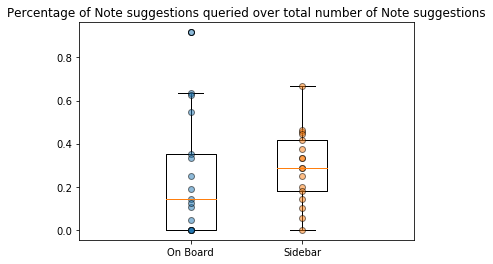

Sample size:
On Board: 17
Sidebar: 17
Means:
On Board: 0.25104405398523044
Sidebar: 0.2933639889522242
Variance:
On Board: 0.07774751799824614
Sidebar: 0.02920746211535691
ShapiroResult(statistic=0.8506954908370972, pvalue=0.010989565402269363)
ShapiroResult(statistic=0.9807201623916626, pvalue=0.9633647203445435)
BartlettResult(statistic=3.5782715159739933, pvalue=0.05854003299903537)
LeveneResult(statistic=1.8526967672787673, pvalue=0.18297888060193226)
Ttest_indResult(statistic=-0.5335424106509852, pvalue=0.5973449786806404)
MannwhitneyuResult(statistic=110.5, pvalue=0.12351805290269391)


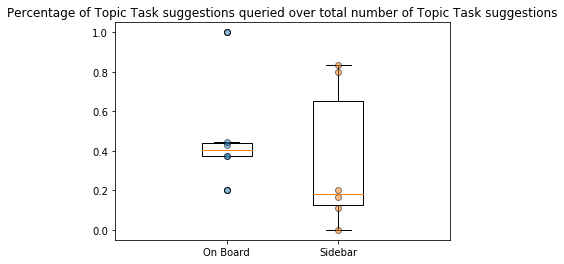

Sample size:
On Board: 6
Sidebar: 6
Means:
On Board: 0.4705026455026455
Sidebar: 0.35185185185185186
Variance:
On Board: 0.07484357940707145
Sidebar: 0.13435390946502057
ShapiroResult(statistic=0.7751861214637756, pvalue=0.03474731370806694)
ShapiroResult(statistic=0.7979158163070679, pvalue=0.05628582462668419)
BartlettResult(statistic=0.3835697031444337, pvalue=0.535698956199126)
LeveneResult(statistic=0.4767086078493478, pvalue=0.5056257160797766)
Ttest_indResult(statistic=0.635430474398752, pvalue=0.5394154433566822)
MannwhitneyuResult(statistic=10.5, pvalue=0.13032906190565646)


In [30]:
suggestiongroups_df_onboard=suggestion_df_joined[suggestion_df_joined['studyType']=='On Board'][['opened', 'suggestionsQueried', 'studyType','boardId', 'grouping']].pivot_table(index=['studyType','boardId'], columns='grouping', aggfunc='mean')
suggestiongroups_df_sidebar=suggestion_df_joined[suggestion_df_joined['studyType']=='Sidebar'][['opened', 'suggestionsQueried', 'studyType','boardId', 'grouping']].pivot_table(index=['studyType','boardId'], columns='grouping', aggfunc='mean')
for item in suggestiongroups_df_onboard['opened'].columns:
    f, ax = plt.subplots()
    ax.boxplot(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(),positions=[1/3])
    ax.boxplot(suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna(),positions=[2/3])
    ax.plot([1/3  for x in range(len(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna()))], suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(), 'o', markeredgecolor='k', alpha=0.5)
    ax.plot([2/3 for x in range(len(suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))], suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna(), 'o', markeredgecolor='k', alpha=0.5)
    plt.xlim([0, 1])
    ax.set_xticks([1/3, 2/3])
    ax.set_xticklabels(['On Board', 'Sidebar'])
    ax.set_title('Percentage of ' + item + ' suggestions queried over total number of ' + item + ' suggestions')
    plt.show()
    print("Sample size:")
    print("On Board: " + str(len(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna())))
    print("Sidebar: " + str(len(suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna())))
    print('Means:')
    print('On Board: ' +str(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna().mean()) )
    print('Sidebar: ' +str(suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna().mean()) )
    print('Variance:')
    print('On Board: ' +str(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna().var()) )
    print('Sidebar: ' +str(suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna().var()) )
    print(stats.shapiro(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna()))
    print(stats.shapiro(suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))
    print(stats.bartlett(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(), suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))
    print(stats.levene(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(), suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))
    print(stats.ttest_ind(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(), suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))
            
    print(stats.mannwhitneyu(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(), suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))
#     if stats.shapiro(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna()).pvalue<0.05 and stats.shapiro(suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()).pvalue<0.05:
#             print(stats.levene(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(), suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))
#             print(stats.ttest_ind(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(), suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))
#     else:
#         print(stats.mannwhitneyu(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(), suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))
# print(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna())

### Total number of suggestions queried by type

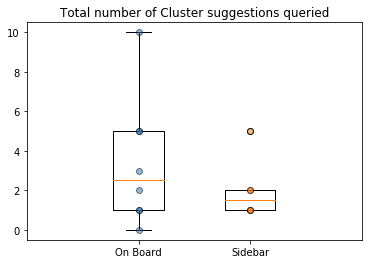

Sample size:
On Board: 8
Sidebar: 6
Means:
On Board: 3.375
Sidebar: 2.0
Variance:
On Board: 10.553571428571429
Sidebar: 2.4
ShapiroResult(statistic=0.8821547031402588, pvalue=0.19745174050331116)
ShapiroResult(statistic=0.7207164764404297, pvalue=0.01014401763677597)
BartlettResult(statistic=2.5248220868085482, pvalue=0.11206741980292649)
LeveneResult(statistic=1.835651074589128, pvalue=0.2004195181753506)
Ttest_indResult(statistic=0.9517361094120719, pvalue=0.36000782604402026)


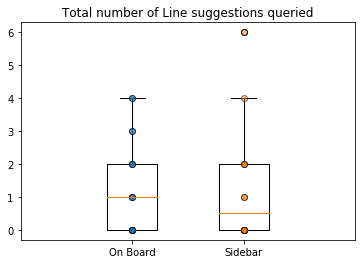

Sample size:
On Board: 17
Sidebar: 14
Means:
On Board: 1.3529411764705883
Sidebar: 1.2857142857142858
Variance:
On Board: 2.11764705882353
Sidebar: 3.296703296703297
ShapiroResult(statistic=0.8373638987541199, pvalue=0.006922083906829357)
ShapiroResult(statistic=0.7515289187431335, pvalue=0.0013336106203496456)
BartlettResult(statistic=0.6836959972639496, pvalue=0.4083169187722442)
LeveneResult(statistic=0.06508048747290256, pvalue=0.8004396653072774)
Ttest_indResult(statistic=0.11450914855747824, pvalue=0.9096233458295184)


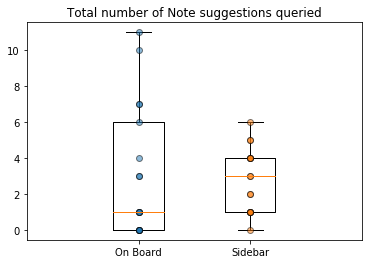

Sample size:
On Board: 17
Sidebar: 17
Means:
On Board: 3.235294117647059
Sidebar: 2.764705882352941
Variance:
On Board: 13.441176470588239
Sidebar: 3.191176470588236
ShapiroResult(statistic=0.8313500881195068, pvalue=0.005643453914672136)
ShapiroResult(statistic=0.9251450300216675, pvalue=0.1803845912218094)
BartlettResult(statistic=7.411474092493433, pvalue=0.006480920031032452)
LeveneResult(statistic=2.5778961384820254, pvalue=0.11819049884860443)
Ttest_indResult(statistic=0.47576082676004217, pvalue=0.6374767539021834)


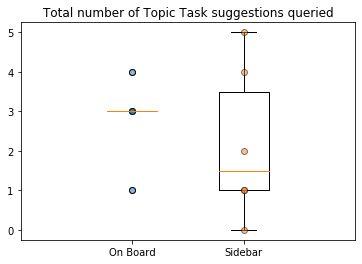

Sample size:
On Board: 6
Sidebar: 6
Means:
On Board: 2.8333333333333335
Sidebar: 2.1666666666666665
Variance:
On Board: 0.9666666666666666
Sidebar: 3.7666666666666666
ShapiroResult(statistic=0.7698016166687012, pvalue=0.030909432098269463)
ShapiroResult(statistic=0.9123750925064087, pvalue=0.4522051513195038)
BartlettResult(statistic=1.9576186608355282, pvalue=0.16176822752589193)
LeveneResult(statistic=2.608695652173913, pvalue=0.13735257071320003)
Ttest_indResult(statistic=0.750586625040802, pvalue=0.47019420700888015)


In [31]:
suggestiongroups_df_onboard=suggestion_df_joined[suggestion_df_joined['studyType']=='On Board'][['opened', 'suggestionsQueried', 'studyType','boardId', 'grouping']].pivot_table(index=['studyType','boardId'], columns='grouping', aggfunc='sum')
suggestiongroups_df_sidebar=suggestion_df_joined[suggestion_df_joined['studyType']=='Sidebar'][['opened', 'suggestionsQueried', 'studyType','boardId', 'grouping']].pivot_table(index=['studyType','boardId'], columns='grouping', aggfunc='sum')
for item in suggestiongroups_df_onboard['opened'].columns:
    f, ax = plt.subplots()
    ax.boxplot(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(),positions=[1/3])
    ax.boxplot(suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna(),positions=[2/3])
    ax.plot([1/3  for x in range(len(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna()))], suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(), 'o', markeredgecolor='k', alpha=0.5)
    ax.plot([2/3 for x in range(len(suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))], suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna(), 'o', markeredgecolor='k', alpha=0.5)
    plt.xlim([0, 1])
    ax.set_xticks([1/3, 2/3])
    ax.set_xticklabels(['On Board', 'Sidebar'])
    ax.set_title('Total number of ' + item + ' suggestions queried')
    plt.show()
    print("Sample size:")
    print("On Board: " + str(len(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna())))
    print("Sidebar: " + str(len(suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna())))
    print('Means:')
    print('On Board: ' +str(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna().mean()) )
    print('Sidebar: ' +str(suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna().mean()) )
    print('Variance:')
    print('On Board: ' +str(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna().var()) )
    print('Sidebar: ' +str(suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna().var()) )
    print(stats.shapiro(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna()))
    print(stats.shapiro(suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))
    print(stats.bartlett(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(), suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))
    print(stats.levene(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(), suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))
    print(stats.ttest_ind(suggestiongroups_df_onboard['suggestionsQueried'][item].dropna(), suggestiongroups_df_sidebar['suggestionsQueried'][item].dropna()))
          

In [32]:
suggestion_df_joined[['opened', 'suggestionsQueried', 'studyType','boardId', 'grouping']].pivot_table(index=['studyType','boardId'], columns='grouping', aggfunc='sum')
aggTotalBoard=aggTotalBoard.join(suggestion_df_joined[['opened', 'suggestionsQueried', 'studyType','boardId', 'grouping']].pivot_table(index=['studyType','boardId'], columns='grouping', aggfunc='sum')['suggestionsQueried']).fillna(0)



## Timeline visualization using test board	

In [33]:
boardId = 'o9J_lthxoSw='
df_queries = browser_df_joined[['timestamp', 'query', 'webpagesVisited','clickedFromMiro']][(browser_df_joined['boardId']==boardId)]
df_queries['timestamp'] = pd.to_datetime(df_queries['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
df_queries['webpagesVisited']=df_queries['webpagesVisited'].astype('float')
df_miroqueries = df_queries[df_queries['clickedFromMiro']==1].set_index('timestamp')
df_queries = df_queries.set_index('timestamp')
df_queries
browser_df_joined[browser_df_joined['boardId']==boardId]

,boardId,timestamp,query,autocomplete,people_also_ask,related_searches,webpagesVisited,clickedFromMiro,studyType,topicTask,time_diff
26,o9J_lthxoSw=,2021-09-30 01:18:25.287663,environmental impacts of covid 19,"['""environmental impacts of covid 19 pandemic""...",['What are some long term effects of COVID-19?...,['positive and negative impact of covid-19 on ...,1,0,On Board,COVID-19,NaT
27,o9J_lthxoSw=,2021-09-30 01:19:09.147357,environmental impacts of covid 19,"['""environmental impacts of covid 19 pandemic""...",['What are some long term effects of COVID-19?...,['positive and negative impact of covid-19 on ...,4,0,On Board,COVID-19,0 days 00:00:43.859694
28,o9J_lthxoSw=,2021-09-30 01:21:16.400895,Tourism Environmental Impacts of COVID-19,"['""tourism environmental impact""', '""tourism i...",['How has the COVID-19 pandemic impacted the e...,['environmental impact of covid-19 on tourism ...,4,1,On Board,COVID-19,0 days 00:02:07.253538
29,o9J_lthxoSw=,2021-09-30 01:29:41.138431,Air pollution Pollution,"['""air pollution pollution essay in urdu""', '""...","['What is air pollution and its effects?', 'Wh...","['Effects of air pollution', 'Effects of air p...",0,1,On Board,COVID-19,0 days 00:08:24.737536
30,o9J_lthxoSw=,2021-09-30 01:29:53.484752,Air pollution Pollution environmental effects ...,"['""air pollution changes due to covid 19""', '""...",NaN,NaN,1,0,On Board,COVID-19,0 days 00:00:12.346321
31,o9J_lthxoSw=,2021-09-30 01:30:02.559217,Air pollution Pollution environmental effects ...,"['""air pollution changes due to covid 19""', '""...",NaN,NaN,0,0,On Board,COVID-19,0 days 00:00:09.074465
32,o9J_lthxoSw=,2021-09-30 01:30:07.087119,Air pollution environmental effects of covid19,"['""air pollution changes due to covid 19""', '""...",NaN,NaN,2,0,On Board,COVID-19,0 days 00:00:04.527902
33,o9J_lthxoSw=,2021-09-30 01:57:09.522793,Tourism Environmental Impacts of COVID-19,"['""tourism environmental impact""', '""tourism i...",NaN,NaN,2,1,On Board,COVID-19,0 days 00:27:02.435674
34,o9J_lthxoSw=,2021-09-30 01:59:31.166648,Invasive alien species Wildlife,"['""invasive alien animal species""', '""what is ...",['How do invasive alien species affect biodive...,"['Invasive species examples', 'Invasive alien ...",0,1,On Board,COVID-19,0 days 00:02:21.643855
35,o9J_lthxoSw=,2021-09-30 02:01:57.468579,Heritage conservation Tourism,"['""heritage conservation and tourism""']",['Why is heritage conservation important to to...,['Negative impact of tourism on historical sit...,1,1,On Board,COVID-19,0 days 00:02:26.301931


In [34]:
boardId = 'o9J_lwTEkh4='
boardHists=pd.read_csv('boardHistory.csv')
def create_suggestions_df(boardId):
    suggestiongroup_df=suggestion_df_joined[suggestion_df_joined['boardId']==boardId].sort_values('timestamp')[['type', 'timestamp']].groupby(['timestamp']).describe().type.top
    df_suggestions=suggestion_df_joined[suggestion_df_joined['boardId']==boardId].sort_values('timestamp')[['type', 'timestamp', 'opened', 'suggestionsQueried']].groupby(['timestamp']).sum()
    df_suggestions['type']=suggestiongroup_df
    df_suggestions['suggestionCount']=suggestion_df_joined[suggestion_df_joined['boardId']==boardId][['type', 'timestamp']].groupby(['timestamp']).count()
    return df_suggestions
def create_queries_df(boardId):
    df_queries = browser_df_joined[['timestamp', 'query', 'webpagesVisited','clickedFromMiro']][(browser_df_joined['boardId']==boardId)]
    df_queries['timestamp'] = pd.to_datetime(df_queries['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
    df_queries['webpagesVisited']=df_queries['webpagesVisited'].astype('float')
    df_miroqueries = df_queries[df_queries['clickedFromMiro']==1].set_index('timestamp')
    df_queries = df_queries.set_index('timestamp')
    return (df_miroqueries, df_queries)
def create_board_df(boardId):
    columns = ['timestamp', 'addedWidgets','totalCharacters']#, 'metadataType']
    board_df = pd.DataFrame(columns = columns)
    board_list=[]
    board_intervals=[]
    boardHist=boardHists[boardHists['boardId']==boardId]
    for key, item in boardHist.iterrows():
        if 'content' in item:
            addedWidgets = 0
            totalCharacters = 0
            content = list(eval(item['content']))
            for widget in content:
                if widget['type']=='LINE' and 'metadata' in widget:
                    continue
                if widget['createdUserId']in ['3074457360807760467', '3074457358223351101']:
                    continue
                text = widget['plainText'] if 'plainText' in widget else ''
                if '🔎︎' in text or '✗' in text:
                    continue
                totalCharacters+=len(text)
                if widget['id'] in board_list:
                    continue
                addedWidgets+=1
                board_list.append(widget['id'])
            board_intervals.append({'timestamp': item['timestamp'], 'addedWidgets': addedWidgets,'totalCharacters': totalCharacters})
            
    board_df=pd.DataFrame(board_intervals)
    board_df['timestamp'] = pd.to_datetime(board_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
    return board_df

In [35]:
boardId = 'o9J_lwTEkh4='
def create_suggestions_df(boardId):
    suggestiongroup_df=suggestion_df_joined[suggestion_df_joined['boardId']==boardId].sort_values('timestamp')[['type', 'timestamp']].groupby(['timestamp']).describe().type.top
    df_suggestions=suggestion_df_joined[suggestion_df_joined['boardId']==boardId].sort_values('timestamp')[['type', 'timestamp', 'opened', 'suggestionsQueried']].groupby(['timestamp']).sum()
    df_suggestions['type']=suggestiongroup_df
    df_suggestions['suggestionCount']=suggestion_df_joined[suggestion_df_joined['boardId']==boardId][['type', 'timestamp']].groupby(['timestamp']).count()
    return df_suggestions
def create_queries_df(boardId):
    df_queries = browser_df_joined[['timestamp', 'query', 'webpagesVisited','clickedFromMiro']][(browser_df_joined['boardId']==boardId)]
    df_queries['timestamp'] = pd.to_datetime(df_queries['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
    df_queries['webpagesVisited']=df_queries['webpagesVisited'].astype('float')
    df_miroqueries = df_queries[df_queries['clickedFromMiro']==1].set_index('timestamp')
    df_queries = df_queries.set_index('timestamp')
    return (df_miroqueries, df_queries)
def create_board_df(boardId):
    print(boardId)
    columns = ['timestamp', 'addedWidgets','totalCharacters']#, 'metadataType']
    board_df = pd.DataFrame(columns = columns)
    board_list=[]
    board_intervals=[]
    boardHist=boardHists[boardHists['boardId']==boardId]
    for key, item in boardHist.iterrows():
        widgetTypes = []
        boundsList = []
        if 'content' in item:
            addedWidgets = 0
            totalCharacters = 0
            content = list(eval(item['content']))
            for widget in content:
                if widget['type']=='LINE' and 'metadata' in widget:
                    continue
                if widget['createdUserId']in ['3074457360807760467', '3074457358223351101']:
                    continue
                text = widget['plainText'] if 'plainText' in widget else ''
                if 'metadata' in widget and client_id in widget['metadata']:
                    widgetType = widget['metadata'][client_id]['type']
                elif 'metadata' in widget and client_id2 in widget['metadata']:
                    widgetType = widget['metadata'][client_id2]['type']
                else:
                    widgetType=widget['type']
                if '🔎︎' in text or '✗' in text:
                    continue
                totalCharacters+=len(text)
                if widget['id'] in board_list:
                    continue
                addedWidgets+=1
                board_list.append(widget['id'])
                widgetTypes.append(widgetType)
                boundsList.append(widget['bounds'])
            board_intervals.append({'timestamp': item['timestamp'], 'addedWidgets': addedWidgets,'totalCharacters': totalCharacters, 'widgetTypes': widgetTypes, 'bounds': boundsList})
            
    board_df=pd.DataFrame(board_intervals)
    board_df['timestamp'] = pd.to_datetime(board_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
    return board_df

In [36]:
create_board_df(boardId)

o9J_lwTEkh4=


,timestamp,addedWidgets,totalCharacters,widgetTypes,bounds
0,2021-09-21 04:08:05.193381,0,0,[],[]
1,2021-09-21 04:08:07.427932,0,0,[],[]
2,2021-09-21 04:08:09.252007,0,0,[],[]
3,2021-09-21 04:08:10.763053,0,0,[],[]
4,2021-09-21 04:08:12.403371,0,0,[],[]
5,2021-09-21 04:09:54.644300,0,0,[],[]
6,2021-09-21 04:11:54.636018,0,0,[],[]
7,2021-09-21 04:13:54.634513,1,0,[IMAGE],"[{'bottom': 1754.7070734735512, 'height': 541...."
8,2021-09-21 04:15:54.647707,0,0,[],[]
9,2021-09-21 04:17:54.659507,0,0,[],[]


### Browser Query Timeline

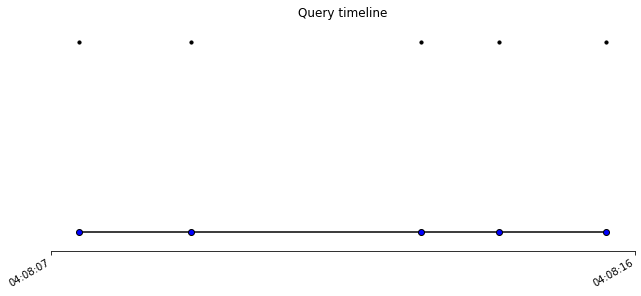

In [37]:

df_miroqueries, df_queries = create_queries_df(boardId)
#print(df_queries.index)
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
ax.set(title="Query timeline")
levels = df_queries['webpagesVisited']
ax.plot(df_queries.index, np.zeros_like(df_queries.index, dtype='int32'), "-o",color="k", markerfacecolor="b")
ax.scatter(df_miroqueries.index, np.full_like(df_miroqueries.index, 1, dtype='int32'),10,marker="o",color="k")
#ax.vlines(df_queries.index, 0, levels, color="tab:red") 

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.margins(y=0.1)
plt.show()

### Full Timeline Activity

In [38]:
def plot_board_activity(boardId):
    df_miroqueries, df_queries = create_queries_df(boardId)
    df_suggestions = create_suggestions_df(boardId)
    board_df = create_board_df(boardId)
    fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
    ax.set(title="Board Activity timeline for " + boardId + ' (' + boardInfo.filter(items=[boardId], axis=0)['studyType'].iloc[0]+')')
    lines = []
    two_minute = timedelta(minutes=2)
    ax.plot(df_suggestions.index, np.full_like(df_suggestions.index,0, dtype='int32'), "-" ,linestyle='None')
    ax.scatter(df_suggestions.index, np.full_like(df_suggestions.index,1, dtype='int32'), df_suggestions['suggestionCount']*10+15, marker="o",color="w",edgecolors='k', label='Query suggested')
    ax.scatter(df_miroqueries.index, np.full_like(df_miroqueries.index, 3, dtype='int32'), df_miroqueries['webpagesVisited']*10+15,marker="o",color="k",edgecolors='k', label='Query issued from Miro')
    ax.scatter(df_queries.index, np.full_like(df_queries.index, 2, dtype='int32'),df_queries['webpagesVisited']*20+15, marker="o",color="b", edgecolors='k',label='Query issued')
    
    midinterval = pd.DataFrame(board_df['timestamp'])-(pd.DataFrame(board_df['timestamp'])-pd.DataFrame(board_df['timestamp']).shift(1))/2
    board_df.iloc[1:, board_df.columns.get_loc('timestamp')]= midinterval['timestamp'][1:]
    board_df['charactersDiff']= board_df['totalCharacters'].diff()
    #print(board_df)
    for index, item in board_df.iterrows():
        
        if item['addedWidgets']>0 or item['charactersDiff']>=50:
            ax.plot(item['timestamp'], 0, "o",color="g", markeredgecolor='k', label='Note Created on Miro')
        
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
    # remove y axis and spines
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(y=0.1)
    
    handles,labels = ax.get_legend_handles_labels()
    handles = [handles[-2], handles[-1], handles[-3], handles[0]]
    labels = [labels[-2], labels[-1], labels[-3], labels[0]]
    ax.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()

o9J_lwTEkh4=


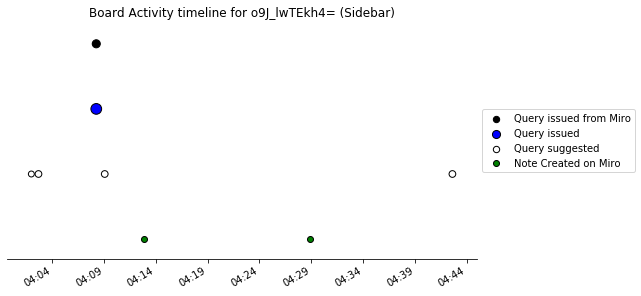

In [39]:
plot_board_activity(boardId)

## Plotting activity for all boards

#### Sidebar Condition

o9J_lth9DEA=


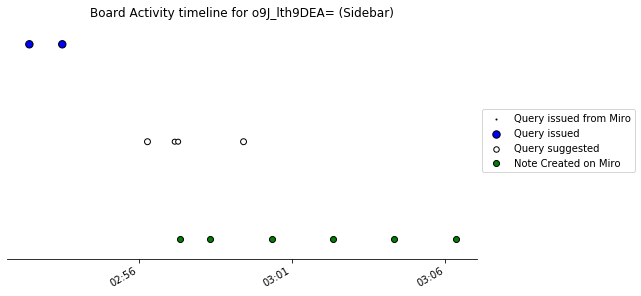

o9J_lthxoK8=


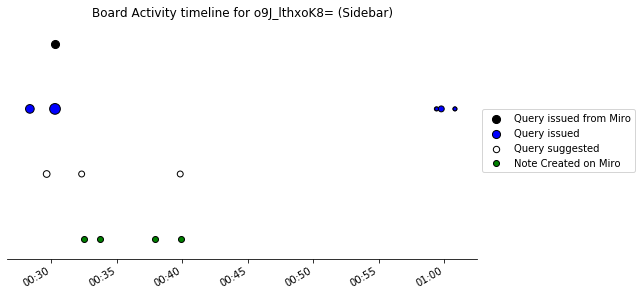

o9J_lwMyp0I=


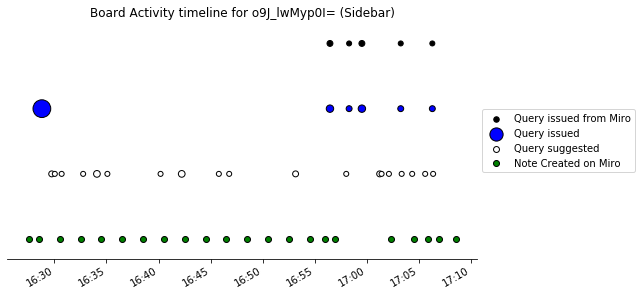

o9J_lwT45UE=


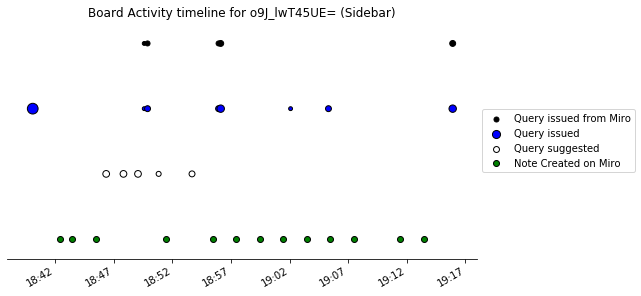

o9J_lwTEkh4=


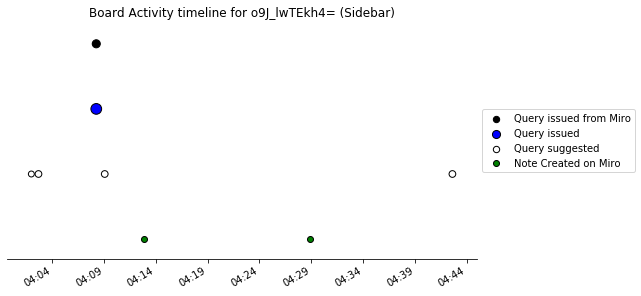

o9J_lwTEnZk=


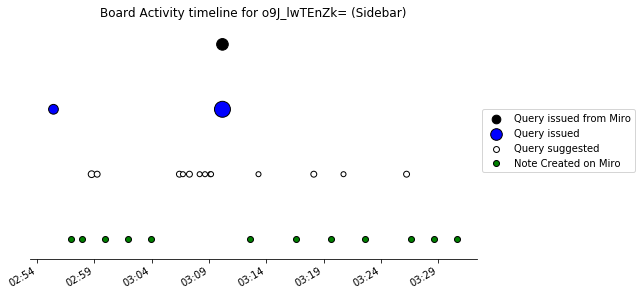

o9J_lwTHmNo=


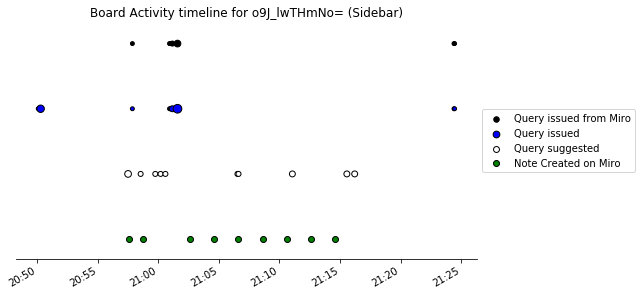

o9J_lwTHmtQ=


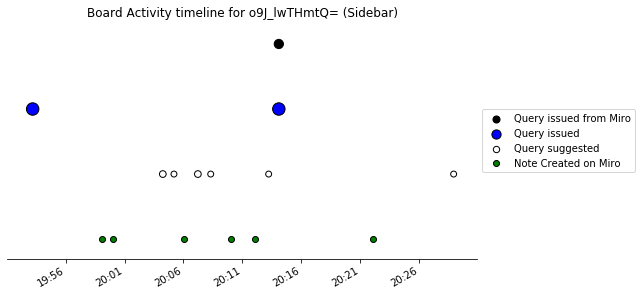

o9J_lwhnitY=


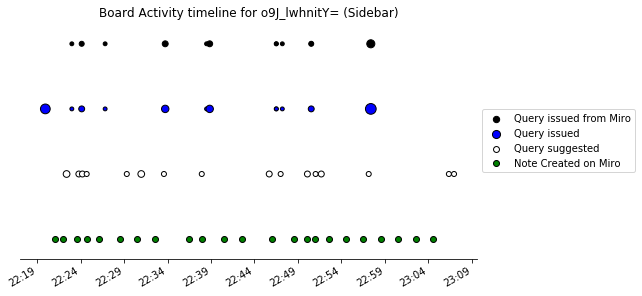

o9J_lwtLWiA=


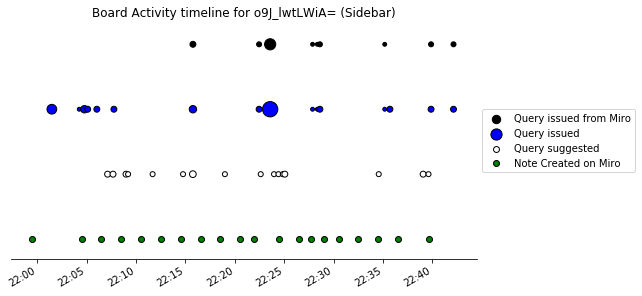

o9J_lxP9EsE=


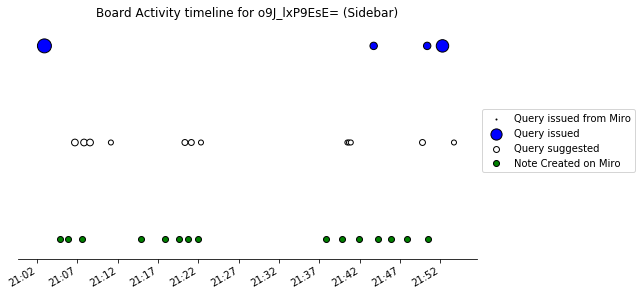

o9J_ly0SnkM=


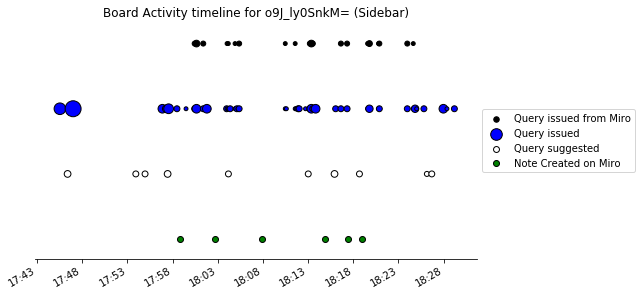

o9J_ly0Snnk=


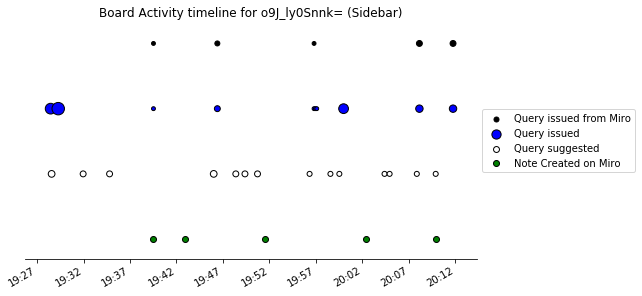

o9J_lyGIfks=


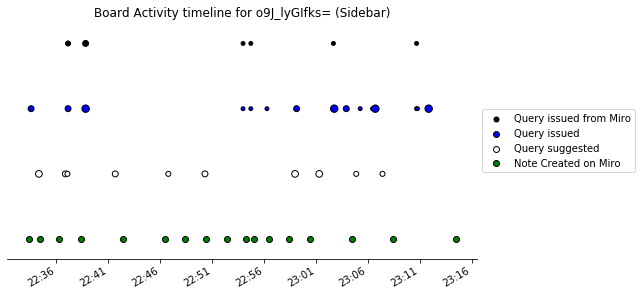

o9J_lyGIfzA=


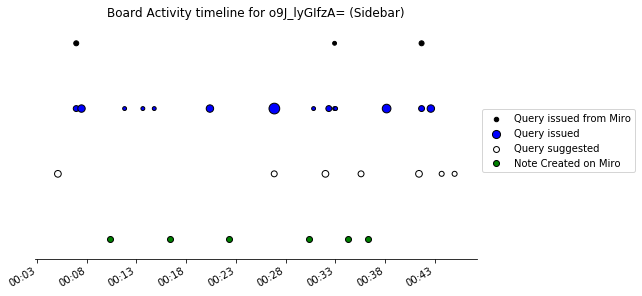

o9J_lyYiAJ0=


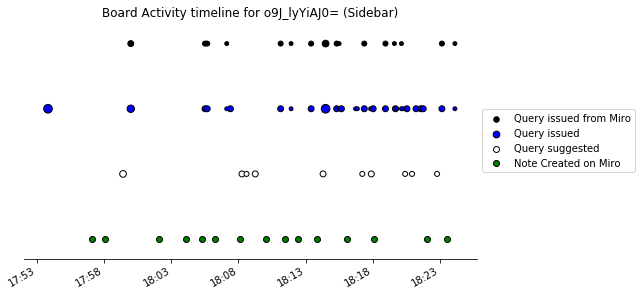

o9J_lzYgHyw=


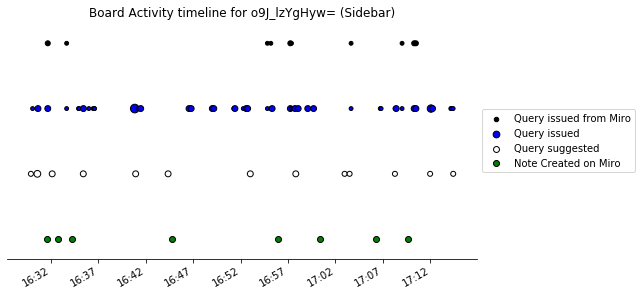

In [40]:
for boardId in sidebarBoards.index.unique():
    plot_board_activity(boardId)

#### On-Board Condition

o9J_lth3zkI=


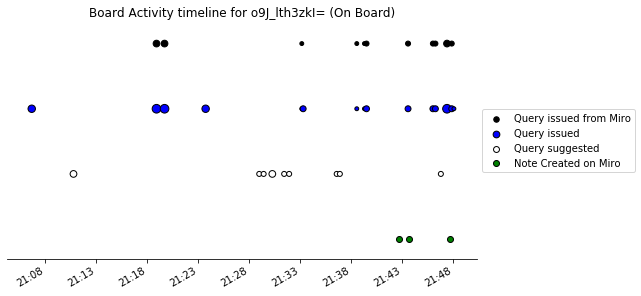

o9J_lthxoSw=


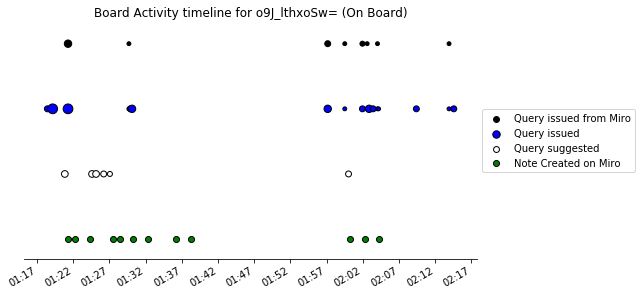

o9J_lwT0kWk=


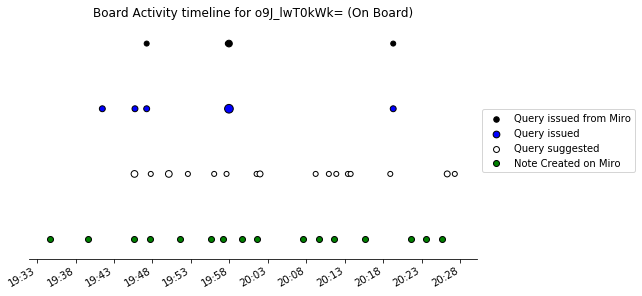

o9J_lwT45Gc=


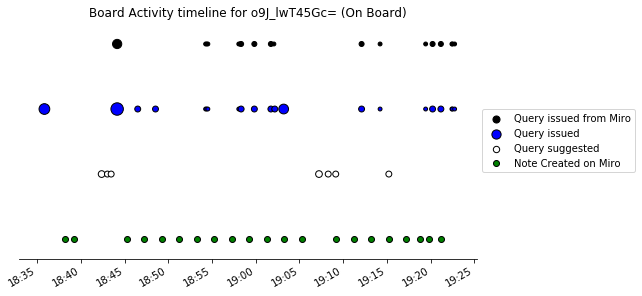

o9J_lwTEnSI=


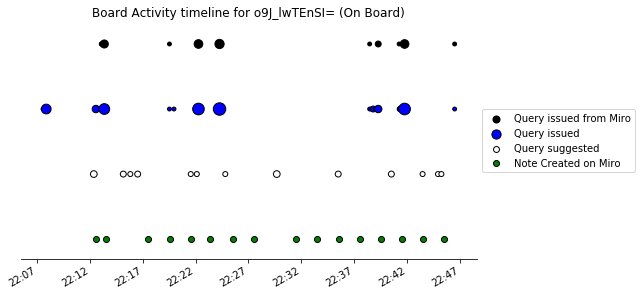

o9J_lwi6_1c=


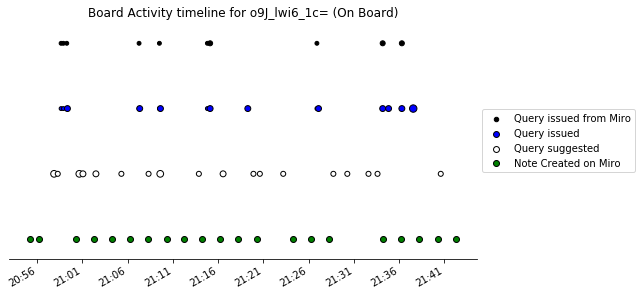

o9J_lwj9wsM=


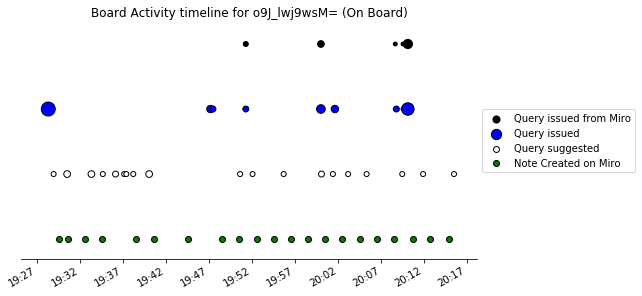

o9J_lwt44k0=


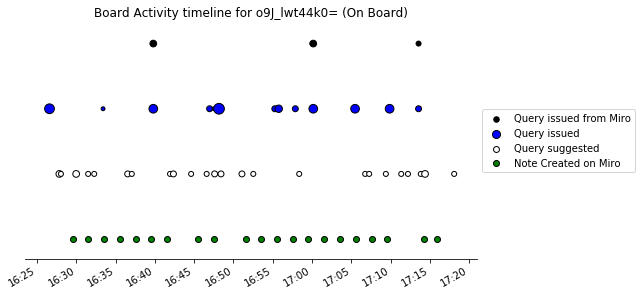

o9J_lwtLWq0=


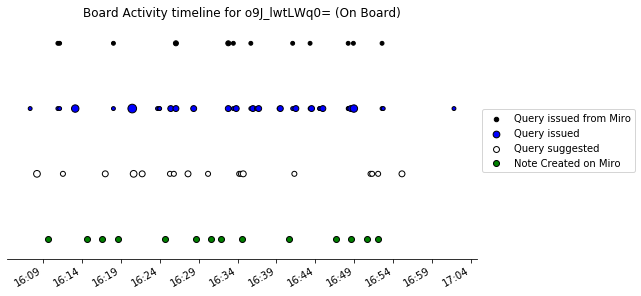

o9J_lwtLZY8=


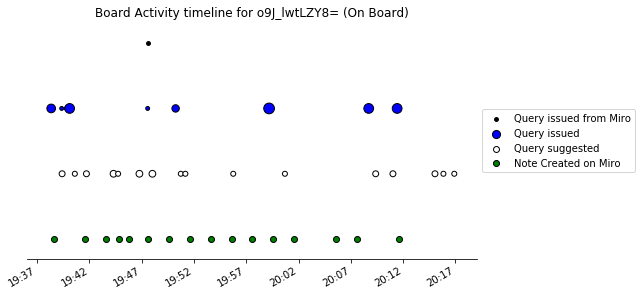

o9J_lx2--OQ=


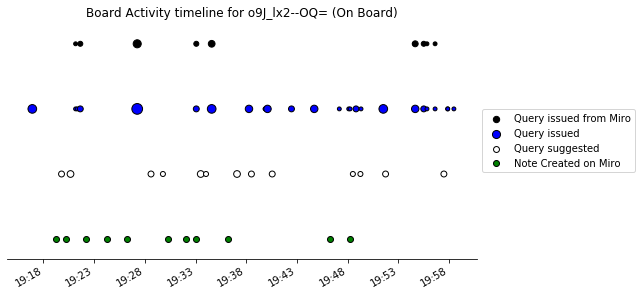

o9J_lxPFjOs=


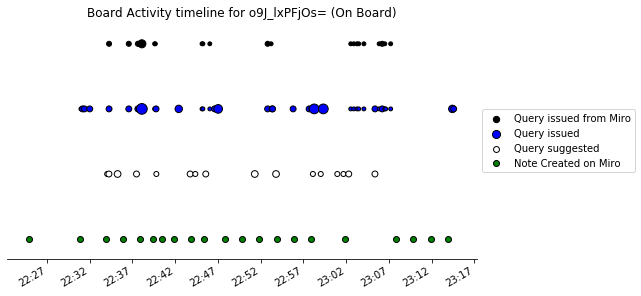

o9J_lxTWUZI=


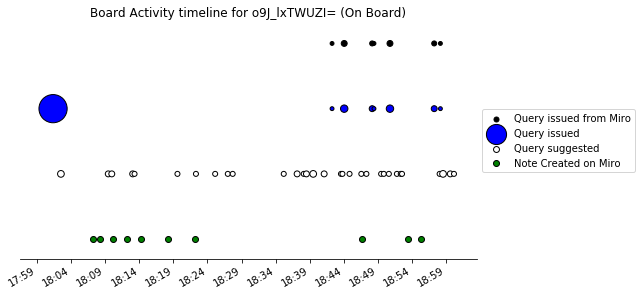

o9J_ly0SnuI=


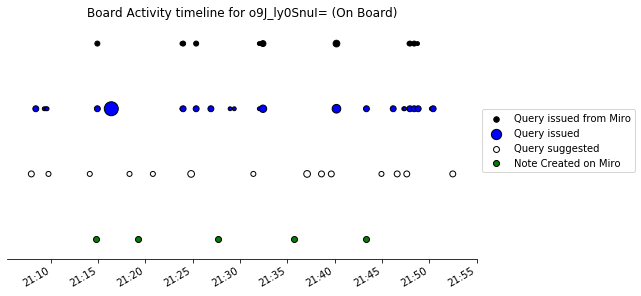

o9J_lyGIeLY=


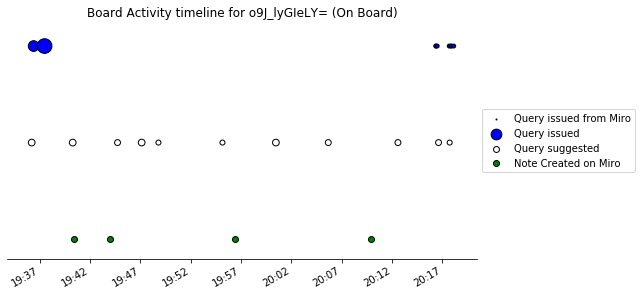

o9J_lyYiALM=


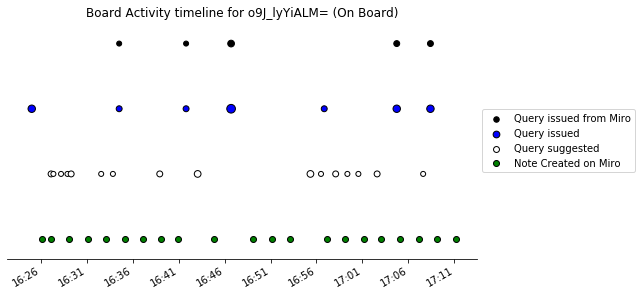

o9J_lzYurAk=


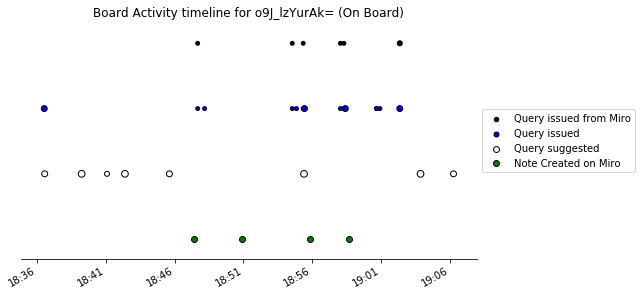

In [41]:
for boardId in onboardBoards.index.unique():
    plot_board_activity(boardId)

## Effect on Sense-making Totals

In [42]:
idx = boardHists.groupby(['boardId'])['timestamp'].transform(max) == boardHists['timestamp']

presentBoards = boardHists[idx]
presentBoards['wordTotal']=0
presentBoards['widgetCount']=0
wordTotals=[]
widgetCounts = []
for row, item in presentBoards.iterrows():
    wordTotal =0
    widgetCount = 0
    for widget in list(eval(item['content'])):
        if widget['createdUserId']in ['3074457360807760467', '3074457358223351101']:
            continue
        text = widget['plainText'] if 'plainText' in widget else ''
        if 'metadata' in widget and client_id in widget['metadata']:
            widgetType = widget['metadata'][client_id]['type']
        elif 'metadata' in widget and client_id2 in widget['metadata']:
            widgetType = widget['metadata'][client_id2]['type']
        else:
            widgetType=widget['type']
        if '🔎︎' in text or '✗' in text:
            continue
        if widget['type']=='LINE':
            continue
        if widgetType not in ['ClusterTitle', 'Cluster']:
            widgetCount+=1
        wordTotal += len(text.split(' '))
    #print(wordTotal)
    wordTotals.append(wordTotal)
    widgetCounts.append(widgetCount)
#     presentBoards.at[key,'wordTotal'] = wordTotal
#     presentBoards.at[key,'widgetCount'] = widgetCount
presentBoards['wordTotal']=wordTotals
presentBoards['widgetCount']=widgetCounts
presentBoards = presentBoards.join(boardInfo, on='boardId')
presentBoards

C:\Users\sheld\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\sheld\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\sheld\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,boardId,id,content,timestamp,wordTotal,widgetCount,studyType,topicTask
12,o9J_lth3zkI=,-Mkn_dP_o6R1Go_1PC2C,"[{'bounds': {'bottom': -56.95547439637653, 'he...",2021-09-29T22:04:39.269573,622,34,On Board,Space Travel
22,o9J_lth9DEA=,-Mkogk_ViqQmNXQ8jNXv,"[{'bounds': {'bottom': 108.36248934295736, 'he...",2021-09-30T03:15:20.801243,181,13,Sidebar,Space Travel
40,o9J_lthxoK8=,-MkoELv5rSPNulE1_XYJ,"[{'bounds': {'bottom': -64.5, 'height': 303, '...",2021-09-30T01:06:53.584191,181,13,Sidebar,COVID-19
73,o9J_lthxoSw=,-MkoWh1ucvdL6Raw7V6G,"[{'bounds': {'bottom': 1044.3195222955671, 'he...",2021-09-30T02:27:02.710785,193,26,On Board,COVID-19
107,o9J_lwMyp0I=,-MjomDBtpGVrP8r3cVBJ,"[{'bounds': {'bottom': 250, 'height': 500, 'le...",2021-09-17T17:23:31.208177,572,27,Sidebar,COVID-19
141,o9J_lwT0kWk=,-MjpTsBU7YG1ZrR8knpt,"[{'bounds': {'bottom': -419.0857650827397, 'he...",2021-09-17T20:38:37.415847,278,8,On Board,Space Travel
175,o9J_lwT45Gc=,-MjzZ3dPym18U33EPqLU,"[{'bounds': {'bottom': 86.58768042961287, 'hei...",2021-09-19T19:37:31.436970,272,27,On Board,COVID-19
204,o9J_lwT45UE=,-Mk3h1fZU1S-f6CP6DEw,"[{'bounds': {'bottom': -171.79086150615348, 'h...",2021-09-20T19:34:48.782584,168,24,Sidebar,COVID-19
226,o9J_lwTEkh4=,-Mk5eFyBCWoQsrChfQT-,"[{'bounds': {'bottom': 106.70499538360457, 'he...",2021-09-21T04:41:55.096957,3,3,Sidebar,COVID-19
278,o9J_lwTEnSI=,-Mk4c0w0LyAoSw0tKgeg,"[{'bounds': {'bottom': 51.55600890140397, 'hei...",2021-09-20T23:52:32.204228,320,24,On Board,Space Travel


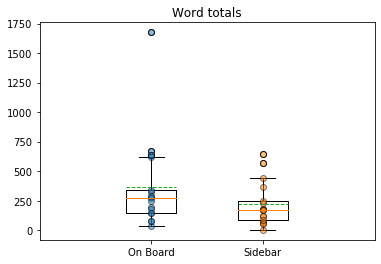

,boardId,id,content,timestamp,wordTotal,widgetCount,studyType,topicTask
12,o9J_lth3zkI=,-Mkn_dP_o6R1Go_1PC2C,"[{'bounds': {'bottom': -56.95547439637653, 'he...",2021-09-29T22:04:39.269573,622,34,On Board,Space Travel
22,o9J_lth9DEA=,-Mkogk_ViqQmNXQ8jNXv,"[{'bounds': {'bottom': 108.36248934295736, 'he...",2021-09-30T03:15:20.801243,181,13,Sidebar,Space Travel
40,o9J_lthxoK8=,-MkoELv5rSPNulE1_XYJ,"[{'bounds': {'bottom': -64.5, 'height': 303, '...",2021-09-30T01:06:53.584191,181,13,Sidebar,COVID-19
73,o9J_lthxoSw=,-MkoWh1ucvdL6Raw7V6G,"[{'bounds': {'bottom': 1044.3195222955671, 'he...",2021-09-30T02:27:02.710785,193,26,On Board,COVID-19
107,o9J_lwMyp0I=,-MjomDBtpGVrP8r3cVBJ,"[{'bounds': {'bottom': 250, 'height': 500, 'le...",2021-09-17T17:23:31.208177,572,27,Sidebar,COVID-19
141,o9J_lwT0kWk=,-MjpTsBU7YG1ZrR8knpt,"[{'bounds': {'bottom': -419.0857650827397, 'he...",2021-09-17T20:38:37.415847,278,8,On Board,Space Travel
175,o9J_lwT45Gc=,-MjzZ3dPym18U33EPqLU,"[{'bounds': {'bottom': 86.58768042961287, 'hei...",2021-09-19T19:37:31.436970,272,27,On Board,COVID-19
204,o9J_lwT45UE=,-Mk3h1fZU1S-f6CP6DEw,"[{'bounds': {'bottom': -171.79086150615348, 'h...",2021-09-20T19:34:48.782584,168,24,Sidebar,COVID-19
226,o9J_lwTEkh4=,-Mk5eFyBCWoQsrChfQT-,"[{'bounds': {'bottom': 106.70499538360457, 'he...",2021-09-21T04:41:55.096957,3,3,Sidebar,COVID-19
278,o9J_lwTEnSI=,-Mk4c0w0LyAoSw0tKgeg,"[{'bounds': {'bottom': 51.55600890140397, 'hei...",2021-09-20T23:52:32.204228,320,24,On Board,Space Travel


In [43]:
f, ax = plt.subplots()
ax.boxplot(presentBoards[presentBoards['studyType']=='On Board']['wordTotal'],positions=[1/3], showmeans=True, meanline=True)
ax.boxplot(presentBoards[presentBoards['studyType']=='Sidebar']['wordTotal'],positions=[2/3],showmeans=True, meanline=True)
ax.plot([1/3  for x in range(len(presentBoards[presentBoards['studyType']=='On Board']['wordTotal']))], presentBoards[presentBoards['studyType']=='On Board']['wordTotal'], 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2/3 for x in range(len(presentBoards[presentBoards['studyType']=='Sidebar']['wordTotal']))], presentBoards[presentBoards['studyType']=='Sidebar']['wordTotal'], 'o', markeredgecolor='k', alpha=0.5)
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
ax.set_title('Word totals')
plt.show()
presentBoards

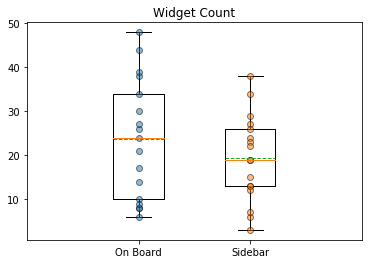

In [44]:
f, ax = plt.subplots()
ax.boxplot(presentBoards[presentBoards['studyType']=='On Board']['widgetCount'],positions=[1/3], showmeans=True, meanline=True)
ax.boxplot(presentBoards[presentBoards['studyType']=='Sidebar']['widgetCount'],positions=[2/3], showmeans=True, meanline=True)
ax.plot([1/3  for x in range(len(presentBoards[presentBoards['studyType']=='On Board']['widgetCount']))], presentBoards[presentBoards['studyType']=='On Board']['widgetCount'], 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2/3 for x in range(len(presentBoards[presentBoards['studyType']=='Sidebar']['widgetCount']))], presentBoards[presentBoards['studyType']=='Sidebar']['widgetCount'], 'o', markeredgecolor='k', alpha=0.5)
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
ax.set_title('Widget Count')
plt.show()

In [45]:
aggTotalBoard=aggTotalBoard.droplevel('studyType')
aggTotalBoard=presentBoards[['boardId','content', 'wordTotal','widgetCount']].join(aggTotalBoard, on='boardId', how='inner')
aggTotalBoard=aggTotalBoard.set_index('boardId')
aggTotalBoard

,content,wordTotal,widgetCount,studyType,topicTask,suggestionsOffered,suggestionsQueried,queriesNotFromMiro,queriesFromMiro,Cluster,Line,Note,Topic Task
boardId,,,,,,,,,,,,,
o9J_lth3zkI=,"[{'bounds': {'bottom': -56.95547439637653, 'he...",622,34,On Board,Space Travel,13,7.0,4.0,12.0,0.0,0.0,7.0,0.0
o9J_lth9DEA=,"[{'bounds': {'bottom': 108.36248934295736, 'he...",181,13,Sidebar,Space Travel,6,0.0,2.0,0.0,0.0,0.0,0.0,0.0
o9J_lthxoK8=,"[{'bounds': {'bottom': -64.5, 'height': 303, '...",181,13,Sidebar,COVID-19,7,1.0,7.0,1.0,0.0,0.0,1.0,0.0
o9J_lthxoSw=,"[{'bounds': {'bottom': 1044.3195222955671, 'he...",193,26,On Board,COVID-19,14,6.0,12.0,8.0,0.0,0.0,6.0,0.0
o9J_lwMyp0I=,"[{'bounds': {'bottom': 250, 'height': 500, 'le...",572,27,Sidebar,COVID-19,26,5.0,1.0,5.0,0.0,0.0,4.0,1.0
o9J_lwT0kWk=,"[{'bounds': {'bottom': -419.0857650827397, 'he...",278,8,On Board,Space Travel,22,5.0,2.0,4.0,0.0,1.0,4.0,0.0
o9J_lwT45Gc=,"[{'bounds': {'bottom': 86.58768042961287, 'hei...",272,27,On Board,COVID-19,16,14.0,6.0,18.0,0.0,3.0,11.0,0.0
o9J_lwT45UE=,"[{'bounds': {'bottom': -171.79086150615348, 'h...",168,24,Sidebar,COVID-19,12,3.0,3.0,5.0,2.0,0.0,1.0,0.0
o9J_lwTEkh4=,"[{'bounds': {'bottom': 106.70499538360457, 'he...",3,3,Sidebar,COVID-19,11,5.0,0.0,5.0,0.0,0.0,5.0,0.0


## Board activity after user sees a suggestions




In [46]:
suggestionCircleClicked_dict

suggCircleActivity=[]
boardInfo[boardInfo['studyType']=='On Board']
for boardId in boardInfo[boardInfo['studyType']=='On Board'].index:
    if boardId in ['o9J_lyYiALg=','o9J_lwrV0Y8=']:
        continue
    for item in suggestionCircleClicked_dict[boardId].dropna():
        suggCircleActivity.append({"boardId": boardId, "suggOpenedTime": datetime.strptime(item,'%Y-%m-%dT%H:%M:%S.%f')})
    
        

suggActivity = pd.DataFrame(suggCircleActivity).sort_values('suggOpenedTime', axis=0).reset_index(drop=True)
suggActivity['suggIntervalEndTime'] = suggActivity.groupby('boardId')['suggOpenedTime'].shift(-1).fillna(datetime.strptime('2030-01-01T00:00:00.000000','%Y-%m-%dT%H:%M:%S.%f'))
suggActivity['addedWidgets']=0
suggActivity['characterDiff']=0

suggActivity[suggActivity['boardId']=='o9J_lwT45Gc=']

,boardId,suggOpenedTime,suggIntervalEndTime,addedWidgets,characterDiff
222,o9J_lwT45Gc=,2021-09-19 18:44:01.240866,2021-09-19 18:54:10.728839,0,0
223,o9J_lwT45Gc=,2021-09-19 18:54:10.728839,2021-09-19 18:54:18.065129,0,0
224,o9J_lwT45Gc=,2021-09-19 18:54:18.065129,2021-09-19 18:54:26.150228,0,0
225,o9J_lwT45Gc=,2021-09-19 18:54:26.150228,2021-09-19 18:57:56.388663,0,0
226,o9J_lwT45Gc=,2021-09-19 18:57:56.388663,2021-09-19 18:58:05.109626,0,0
227,o9J_lwT45Gc=,2021-09-19 18:58:05.109626,2021-09-19 18:58:13.697926,0,0
228,o9J_lwT45Gc=,2021-09-19 18:58:13.697926,2021-09-19 19:04:05.851793,0,0
229,o9J_lwT45Gc=,2021-09-19 19:04:05.851793,2021-09-19 19:12:01.145443,0,0
230,o9J_lwT45Gc=,2021-09-19 19:12:01.145443,2021-09-19 19:12:13.116410,0,0
231,o9J_lwT45Gc=,2021-09-19 19:12:13.116410,2021-09-19 19:14:06.655686,0,0


In [47]:
webpage_df =pd.read_csv('webpage_df.csv')
for boardId in boardInfo[boardInfo['studyType']=='On Board'].index:
    board_df = create_board_df(boardId)
    board_df['charDiff']=board_df['totalCharacters'].diff()
    webpageboard_df=webpage_df[webpage_df['boardId']==boardId]
    webpageboard_df['timestamp'] = pd.to_datetime(webpageboard_df['timestamp'])
    for key, item in suggActivity[suggActivity['boardId']==boardId].iterrows():
        suggIntervalActivity = board_df[(board_df['timestamp']<item.suggIntervalEndTime) & (board_df['timestamp']>=item.suggOpenedTime)]
        webpageIntervalActivity = webpageboard_df[(webpageboard_df['timestamp']<item.suggIntervalEndTime) & (webpageboard_df['timestamp']>=item.suggOpenedTime)]
        suggActivity.at[key, 'addedWidgets']=suggIntervalActivity['addedWidgets'].sum()
        suggActivity.at[key, 'characterDiff']=suggIntervalActivity['charDiff'].sum()
        suggActivity.at[key, 'webpagesOpened'] = webpageIntervalActivity[webpageIntervalActivity['isQuery'] == False]['isQuery'].count()
        suggActivity.at[key, 'queriesOpened'] = webpageIntervalActivity[webpageIntervalActivity['isQuery'] == True]['isQuery'].count()
suggActivity

o9J_lth3zkI=
o9J_lthxoSw=


C:\Users\sheld\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


o9J_lwT0kWk=
o9J_lwT45Gc=
o9J_lwTEnSI=
o9J_lwi6_1c=
o9J_lwj9wsM=
o9J_lwt44k0=
o9J_lwtLWq0=
o9J_lwtLZY8=
o9J_lx2--OQ=
o9J_lxPFjOs=
o9J_lxTWUZI=
o9J_ly0SnuI=
o9J_lyGIeLY=
o9J_lyYiALM=
o9J_lzYurAk=


,boardId,suggOpenedTime,suggIntervalEndTime,addedWidgets,characterDiff,webpagesOpened,queriesOpened
0,o9J_lzYurAk=,2021-09-03 18:47:25.484276,2021-09-03 18:47:28.787963,0,0,0.0,0.0
1,o9J_lzYurAk=,2021-09-03 18:47:28.787963,2021-09-03 18:54:21.235389,9,-30,0.0,2.0
2,o9J_lzYurAk=,2021-09-03 18:54:21.235389,2021-09-03 18:57:21.836655,1,675,1.0,4.0
3,o9J_lzYurAk=,2021-09-03 18:57:21.836655,2021-09-03 18:57:26.867164,0,0,0.0,0.0
4,o9J_lzYurAk=,2021-09-03 18:57:26.867164,2021-09-03 18:57:29.259117,0,0,0.0,0.0
...,...,...,...,...,...,...,...
312,o9J_lthxoSw=,2021-09-30 02:13:50.098427,2021-09-30 02:13:56.932531,0,0,0.0,1.0
313,o9J_lthxoSw=,2021-09-30 02:13:56.932531,2021-09-30 02:14:01.982136,0,0,0.0,0.0
314,o9J_lthxoSw=,2021-09-30 02:14:01.982136,2021-09-30 02:14:09.666602,0,0,0.0,0.0
315,o9J_lthxoSw=,2021-09-30 02:14:09.666602,2021-09-30 02:21:03.571655,0,0,1.0,2.0


### Mapping widgets to browser queries

In [48]:
widgets_df =pd.read_csv('widgets.csv')
widgets_df['id']= widgets_df['id'].astype('string')
widgets_df

,board_id,id,timestamp,text,bounds,type
0,o9J_lth3zkI=,3074457364776383547,2021-09-29 21:42:39.248845,NaN,"{'bottom': -56.95547439637653, 'height': 707.3...",IMAGE
1,o9J_lth3zkI=,3074457364844215293,2021-09-29 21:42:39.248845,NaN,"{'bottom': 488.883751851557, 'height': 180, 'l...",IMAGE
2,o9J_lth3zkI=,3074457364843888861,2021-09-29 21:42:39.248845,Voyager,"{'bottom': 291.07418127970703, 'height': 51.59...",TEXT
3,o9J_lth3zkI=,3074457364843888784,2021-09-29 21:42:39.248845,NaN,"{'bottom': 632.605668173259, 'height': 535.175...",SHAPE
4,o9J_lth3zkI=,3074457364843701369,2021-09-29 21:42:39.248845,Transportation,"{'bottom': 196.15278603818928, 'height': 68.57...",TEXT
...,...,...,...,...,...,...
31904,o9J_lzYurAk=,3074457363437014414,2021-09-09 23:07:35.998728,NaN,"{'bottom': 3497.450131579215, 'height': 3017.3...",Cluster
31905,o9J_lzYurAk=,3074457363436856036,2021-09-09 23:07:35.998728,the way each country is being affected,"{'bottom': 2173.4252340465396, 'height': 85.29...",TEXT
31906,o9J_lzYurAk=,3074457363436855852,2021-09-09 23:07:35.998728,"By 2040 (panel B), both the economic losses an...","{'bottom': 1265.0455774774787, 'height': 459.2...",STICKER
31907,o9J_lzYurAk=,3074457363436856547,2021-09-09 23:07:35.998728,NaN,"{'bottom': 3418.237446835442, 'height': 1244.8...",IMAGE


In [49]:
for boardId in boardInfo.index:
    for key, item in browser_df_joined[(browser_df_joined['boardId']==boardId) & (browser_df_joined['clickedFromMiro']==1)].iterrows():
#         print(item['query'])
        relevantSuggestions = suggestion_df_joined[suggestion_df_joined['boardId']==boardId]
        relevantSuggestions=relevantSuggestions[relevantSuggestions['suggestionsQueried']==1]
#         if 'Vaccine transportation' not in item.query:
#             continue
#         print(relevantSuggestions)
        for key2, item2 in relevantSuggestions.iterrows():
            if item2.suggestionText not in item.query:
                relevantSuggestions=relevantSuggestions.drop(index=key2)
#         print(relevantSuggestions)
        relevantSuggestions = relevantSuggestions[relevantSuggestions['timestamp']< item.timestamp]
#         for key2, item2 in relevantSuggestions.iterrows():
#             if item2.status==4 and item2.lastUpdated>item.timestamp:
#                 relevantSuggestions=relevantSuggestions.drop(index=key2)
#         print(relevantSuggestions)
        if len(relevantSuggestions)>0:
            widgettypes=[]
            relevantSuggestions = relevantSuggestions.sort_values('lastUpdated').iloc[0]
#             print(relevantSuggestions)
            parentWidgetA = widgets_df[widgets_df['id']==relevantSuggestions['parentIdA']]
#             print(parentWidgetA)
            parentWidgetA['timestamp'] = pd.to_datetime(parentWidgetA['timestamp'])
            parentWidgetA = parentWidgetA[parentWidgetA['timestamp']<item.timestamp]
            parentWidgetB=widgets_df[widgets_df['id']==relevantSuggestions['parentIdB']]
            parentWidgetB['timestamp'] = pd.to_datetime(parentWidgetB['timestamp'])
            parentWidgetB = parentWidgetB[parentWidgetB['timestamp']<item.timestamp]
            widgetPosition=None
            if relevantSuggestions['parentIdB']!=0 and len(parentWidgetB)!=0:
                #print('yay')
                parentWidgetB = parentWidgetB.sort_values('timestamp',ascending=False).iloc[0]
                widgettypes.append(parentWidgetB.type)
                bounds2 = eval(parentWidgetB.bounds)
                positionX = (bounds['x']+bounds2['x'])/2
                positionY=(bounds['y']+bounds2['y'])/2
                widgetPosition = {'x':positionX, 'y':positionY}
#                 print(widgetPosition)
                #browser_df_joined.at[key, 'parentWidgetBType']=parentWidgetB.type
                #browser_df_joined.at[key, 'parentWidgetBBounds']=parentWidgetB.bounds
            if len(parentWidgetA)!=0:
                parentWidgetA=parentWidgetA.sort_values('timestamp',ascending=False).iloc[0]
                widgettypes.append(parentWidgetA.type)
                bounds = eval(parentWidgetA.bounds)
                #print(bounds)
                if widgetPosition is None:
                    widgetPosition = {'x': bounds['x'], 'y':bounds['y']}
                
#                 print(type(bounds['x']))
#                 print(type(widgetPosition))
#                 print(str(widgetPosition))
                
                browser_df_joined.at[key, 'parentWidgetTypes']=widgettypes
                browser_df_joined.at[key, 'positionX']=widgetPosition['x']
                browser_df_joined.at[key, 'positionY']=widgetPosition['y']
                #browser_df_joined.at[key, 'parentWidgetAType']=parentWidgetA.type
                #browser_df_joined.at[key, 'parentWidgetABounds']=parentWidgetA.bounds
            
            else:
                parentWidgetA = widgets_df[widgets_df['id']==relevantSuggestions['parentIdA']]
                parentWidgetA['timestamp'] = pd.to_datetime(parentWidgetA['timestamp'])
                parentWidgetA=parentWidgetA.sort_values('timestamp',ascending=False).iloc[0]
                widgettypes.append(parentWidgetA.type)
                bounds = eval(parentWidgetA.bounds)
                widgetPosition = {'x': bounds['x'], 'y':bounds['y']}
                browser_df_joined.at[key, 'parentWidgetTypes']=widgettypes
                browser_df_joined.at[key, 'positionX']=widgetPosition['x']
                browser_df_joined.at[key, 'positionY']=widgetPosition['y']
       
browser_df_joined[browser_df_joined['boardId']=='o9J_lth3zkI=']
        


C:\Users\sheld\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sheld\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sheld\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,boardId,timestamp,query,autocomplete,people_also_ask,related_searches,webpagesVisited,clickedFromMiro,studyType,topicTask,time_diff,parentWidgetTypes,positionX,positionY
0,o9J_lth3zkI=,2021-09-29 21:06:39.990358,futurization of space travel,[''],"['What are the main dangers of space travel?',...","['Space travel history', 'Space exploration es...",2,0,On Board,Space Travel,NaT,NaN,NaN,NaN
1,o9J_lth3zkI=,2021-09-29 21:18:54.440814,NASA%27s Commerical Crew Program,"['""nasa commercial crew program""', '""nasa comm...",NaN,"['Commercial Crew Program SpaceX', 'What is th...",3,1,On Board,Space Travel,0 days 00:12:14.450456,NaN,NaN,NaN
2,o9J_lth3zkI=,2021-09-29 21:19:34.988778,Voyager,"['""voyager crypto""', '""voyager estates""', '""vo...","['Where is Voyager right now?', 'Is Voyager 1 ...","['Voyager crypto', 'Voyager login', 'Voyager T...",0,1,On Board,Space Travel,0 days 00:00:40.547964,SHAPE,1053.423988,-312.417602
3,o9J_lth3zkI=,2021-09-29 21:19:41.735419,Space hotels,"['""space hotel 2027""', '""space hotels of the f...",['How much will it cost to stay in the space h...,"['Space hotel room', 'Inside space hotel', 'Vo...",3,1,On Board,Space Travel,0 days 00:00:06.746641,[SHAPE],1053.423988,-312.417602
4,o9J_lth3zkI=,2021-09-29 21:23:43.626427,Space hotels,"['""space hotel 2027""', '""space hotels of the f...",NaN,NaN,2,0,On Board,Space Travel,0 days 00:04:01.891008,NaN,NaN,NaN
5,o9J_lth3zkI=,2021-09-29 21:33:09.696241,Voyager,"['""voyager crypto""', '""voyager estates""', '""vo...","['Where is Voyager right now?', 'Is Voyager 1 ...","['Voyager crypto', 'Voyager login', 'Voyager T...",0,1,On Board,Space Travel,0 days 00:09:26.069814,[SHAPE],1053.423988,-312.417602
6,o9J_lth3zkI=,2021-09-29 21:33:17.710755,Voyager Futurization of Space Travel,[''],"['What speed is Voyager 1 traveling at?', 'Wha...","['Voyager 1 current position', 'Voyager 1 last...",1,0,On Board,Space Travel,0 days 00:00:08.014514,NaN,NaN,NaN
7,o9J_lth3zkI=,2021-09-29 21:38:33.406144,2015 SPACE Act,"['""2015 space act""', '""space act 2015 pdf""']",NaN,"['SPACE Act of 2015 summary', 'Space resource ...",0,1,On Board,Space Travel,0 days 00:05:15.695389,[SHAPE],1053.423988,-312.417602
8,o9J_lth3zkI=,2021-09-29 21:39:18.561758,FAA Recommended Practices 280 guests and 112 c...,[''],NaN,['FAA pilot and medical certification requirem...,0,1,On Board,Space Travel,0 days 00:00:45.155614,[TEXT],1138.818644,436.008311
9,o9J_lth3zkI=,2021-09-29 21:39:30.680243,Satellite communication Transportation,[''],"['How do satellites help in transportation?', ...",NaN,1,1,On Board,Space Travel,0 days 00:00:12.118485,[TEXT],1983.453678,161.867072


## Board activity after user opens a suggestions

In [50]:
miroQueries_df=browser_df_joined[browser_df_joined['clickedFromMiro']==1]
browser_df_joined['timeIntervalEnd'] = browser_df_joined.groupby('boardId')['timestamp'].shift(-1).fillna(datetime.strptime('2030-01-01T00:00:00.000000','%Y-%m-%dT%H:%M:%S.%f'))
browser_df_joined['addedWidgets']=0
browser_df_joined['characterDiff']=0

for boardId in boardInfo.index:
    board_df = create_board_df(boardId)
    board_df['charDiff']=board_df['totalCharacters'].diff()
    #print(board_df)
    webpageboard_df=webpage_df[webpage_df['boardId']==boardId]
    webpageboard_df['timestamp'] = pd.to_datetime(webpageboard_df['timestamp'])
    for key, item in browser_df_joined[browser_df_joined['boardId']==boardId].iterrows():
        #print(item)
        suggIntervalActivity = board_df[(board_df['timestamp']<item.timeIntervalEnd) & (board_df['timestamp']>=item.timestamp)]
        webpageIntervalActivity = webpageboard_df[(webpageboard_df['timestamp']<item.timeIntervalEnd) & (webpageboard_df['timestamp']>=item.timestamp)]
        positionX = item['positionX'] if 'positionX' in item else None
        positionY = item['positionY'] if 'positionY' in item else None
        totalDistance=None
        numOfWidgets=None
#         print(item)
        if item['clickedFromMiro']==1 and item['addedWidgets']==0:
            totalDistance=0
            numOfWidgets=0
            for bounds in suggIntervalActivity['bounds']:
                for bound in bounds:
                    totalDistance +=math.sqrt((positionX-bound['x'])**2 + (positionY-bound['y'])**2)
                    numOfWidgets+=1
        browser_df_joined.at[key, 'averageDistance'] = None if totalDistance==0 or totalDistance is None else totalDistance/numOfWidgets
        browser_df_joined.at[key, 'addedWidgets']=suggIntervalActivity['addedWidgets'].sum()
        browser_df_joined.at[key, 'characterDiff']=suggIntervalActivity['charDiff'].sum()
        browser_df_joined.at[key, 'webpagesOpened'] = webpageIntervalActivity[webpageIntervalActivity['isQuery'] == False]['isQuery'].count()
browser_df_joined[(browser_df_joined['clickedFromMiro']==1)]

o9J_lth3zkI=
o9J_lth9DEA=
o9J_lthxoK8=


C:\Users\sheld\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


o9J_lthxoSw=
o9J_lwMyp0I=
o9J_lwT0kWk=
o9J_lwT45Gc=
o9J_lwT45UE=
o9J_lwTEkh4=
o9J_lwTEnSI=
o9J_lwTEnZk=
o9J_lwTHmNo=
o9J_lwTHmtQ=
o9J_lwhnitY=
o9J_lwi6_1c=
o9J_lwj9wsM=
o9J_lwt44k0=
o9J_lwtLWiA=
o9J_lwtLWq0=
o9J_lwtLZY8=
o9J_lx2--OQ=
o9J_lxP9EsE=
o9J_lxPFjOs=
o9J_lxTWUZI=
o9J_ly0SnkM=
o9J_ly0Snnk=
o9J_ly0SnuI=
o9J_lyGIeLY=
o9J_lyGIfks=
o9J_lyGIfzA=
o9J_lyYiAJ0=
o9J_lyYiALM=
o9J_lzYgHyw=
o9J_lzYurAk=


,boardId,timestamp,query,autocomplete,people_also_ask,related_searches,webpagesVisited,clickedFromMiro,studyType,topicTask,time_diff,parentWidgetTypes,positionX,positionY,timeIntervalEnd,addedWidgets,characterDiff,averageDistance,webpagesOpened
1,o9J_lth3zkI=,2021-09-29 21:18:54.440814,NASA%27s Commerical Crew Program,"['""nasa commercial crew program""', '""nasa comm...",NaN,"['Commercial Crew Program SpaceX', 'What is th...",3,1,On Board,Space Travel,0 days 00:12:14.450456,NaN,NaN,NaN,2021-09-29 21:19:34.988778,0,0,NaN,3.0
2,o9J_lth3zkI=,2021-09-29 21:19:34.988778,Voyager,"['""voyager crypto""', '""voyager estates""', '""vo...","['Where is Voyager right now?', 'Is Voyager 1 ...","['Voyager crypto', 'Voyager login', 'Voyager T...",0,1,On Board,Space Travel,0 days 00:00:40.547964,SHAPE,1053.423988,-312.417602,2021-09-29 21:19:41.735419,0,0,NaN,0.0
3,o9J_lth3zkI=,2021-09-29 21:19:41.735419,Space hotels,"['""space hotel 2027""', '""space hotels of the f...",['How much will it cost to stay in the space h...,"['Space hotel room', 'Inside space hotel', 'Vo...",3,1,On Board,Space Travel,0 days 00:00:06.746641,[SHAPE],1053.423988,-312.417602,2021-09-29 21:23:43.626427,0,0,NaN,3.0
5,o9J_lth3zkI=,2021-09-29 21:33:09.696241,Voyager,"['""voyager crypto""', '""voyager estates""', '""vo...","['Where is Voyager right now?', 'Is Voyager 1 ...","['Voyager crypto', 'Voyager login', 'Voyager T...",0,1,On Board,Space Travel,0 days 00:09:26.069814,[SHAPE],1053.423988,-312.417602,2021-09-29 21:33:17.710755,0,0,NaN,0.0
7,o9J_lth3zkI=,2021-09-29 21:38:33.406144,2015 SPACE Act,"['""2015 space act""', '""space act 2015 pdf""']",NaN,"['SPACE Act of 2015 summary', 'Space resource ...",0,1,On Board,Space Travel,0 days 00:05:15.695389,[SHAPE],1053.423988,-312.417602,2021-09-29 21:39:18.561758,0,0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,o9J_lzYurAk=,2021-09-03 18:54:33.114790,Air pollution,"['""air pollution control district""', '""air pol...","['What are main causes of air pollution?', 'Wh...","['Air pollution causes', 'Effects of air pollu...",0,1,On Board,COVID-19,0 days 00:06:22.539964,"[TEXT, TEXT]",965.883288,614.421503,2021-09-03 18:54:51.209324,0,0,NaN,0.0
569,o9J_lzYurAk=,2021-09-03 18:55:20.751356,Plastic pollution,"['""plastic pollution in the ocean""', '""plastic...","['What are the effects of plastic pollution?',...","['Plastic pollution facts', 'Plastic pollution...",0,1,On Board,COVID-19,0 days 00:00:29.542032,"[TEXT, TEXT]",934.343136,757.279839,2021-09-03 18:55:26.500804,0,0,NaN,0.0
571,o9J_lzYurAk=,2021-09-03 18:58:03.162211,Municipal solid waste ENVIRONMENT,"['""municipal solid waste environmental impact""...",['How does municipal solid waste affect the en...,"['Municipal solid waste examples', 'Municipal ...",0,1,On Board,COVID-19,0 days 00:02:36.661407,[ClusterTitle],2039.732004,428.522487,2021-09-03 18:58:18.340120,0,0,NaN,0.0
572,o9J_lzYurAk=,2021-09-03 18:58:18.340120,Recycling Programs ENVIRONMENT,"['""recycling for the environment""']",['How do recycling programs help the environme...,"['Is recycling good for the environment', 'Eco...",0,1,On Board,COVID-19,0 days 00:00:15.177909,[ClusterTitle],2039.732004,428.522487,2021-09-03 18:58:24.475979,0,0,NaN,0.0


In [51]:
miroQueries_df['timeIntervalEnd'] = miroQueries_df.groupby('boardId')['timestamp'].shift(-1).fillna(datetime.strptime('2030-01-01T00:00:00.000000','%Y-%m-%dT%H:%M:%S.%f'))
miroQueries_df['addedWidgets']=0
miroQueries_df['characterDiff']=0
for boardId in boardInfo.index:
    board_df = create_board_df(boardId)
    board_df['charDiff']=board_df['totalCharacters'].diff()
    #print(board_df)
    webpageboard_df=webpage_df[webpage_df['boardId']==boardId]
    webpageboard_df['timestamp'] = pd.to_datetime(webpageboard_df['timestamp'])
    for key, item in miroQueries_df[miroQueries_df['boardId']==boardId].iterrows():
        suggIntervalActivity = board_df[(board_df['timestamp']<item.timeIntervalEnd) & (board_df['timestamp']>=item.timestamp)]
        webpageIntervalActivity = webpageboard_df[(webpageboard_df['timestamp']<item.timeIntervalEnd) & (webpageboard_df['timestamp']>=item.timestamp)]
        positionX = item['positionX']
        positionY = item['positionY']
        totalDistance=None
        numOfWidgets=None
        if item['clickedFromMiro']==1 and item['addedWidgets']==0:
            totalDistance=0
            numOfWidgets=0
            for bounds in suggIntervalActivity['bounds']:
                for bound in bounds:
                    totalDistance +=math.sqrt((positionX-bound['x'])**2 + (positionY-bound['y'])**2)
                    numOfWidgets+=1
        miroQueries_df.at[key, 'averageDistance'] = None if totalDistance==0 or totalDistance is None else totalDistance/numOfWidgets
        miroQueries_df.at[key, 'addedWidgets']=suggIntervalActivity['addedWidgets'].sum()
        miroQueries_df.at[key, 'characterDiff']=suggIntervalActivity['charDiff'].sum()
        miroQueries_df.at[key, 'webpagesOpened'] = webpageIntervalActivity[webpageIntervalActivity['isQuery'] == False]['isQuery'].count()
miroQueries_df[(miroQueries_df['addedWidgets']>1) ]

C:\Users\sheld\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\sheld\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\sheld\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

o9J_lth3zkI=
o9J_lth9DEA=
o9J_lthxoK8=
o9J_lthxoSw=
o9J_lwMyp0I=
o9J_lwT0kWk=
o9J_lwT45Gc=
o9J_lwT45UE=
o9J_lwTEkh4=
o9J_lwTEnSI=
o9J_lwTEnZk=
o9J_lwTHmNo=
o9J_lwTHmtQ=
o9J_lwhnitY=
o9J_lwi6_1c=
o9J_lwj9wsM=
o9J_lwt44k0=
o9J_lwtLWiA=
o9J_lwtLWq0=
o9J_lwtLZY8=
o9J_lx2--OQ=
o9J_lxP9EsE=
o9J_lxPFjOs=
o9J_lxTWUZI=
o9J_ly0SnkM=
o9J_ly0Snnk=
o9J_ly0SnuI=
o9J_lyGIeLY=
o9J_lyGIfks=
o9J_lyGIfzA=
o9J_lyYiAJ0=
o9J_lyYiALM=
o9J_lzYgHyw=
o9J_lzYurAk=


,boardId,timestamp,query,autocomplete,people_also_ask,related_searches,webpagesVisited,clickedFromMiro,studyType,topicTask,time_diff,parentWidgetTypes,positionX,positionY,timeIntervalEnd,addedWidgets,characterDiff,averageDistance,webpagesOpened
9,o9J_lth3zkI=,2021-09-29 21:39:30.680243,Satellite communication Transportation,[''],"['How do satellites help in transportation?', ...",NaN,1,1,On Board,Space Travel,0 days 00:00:12.118485,[TEXT],1983.453678,161.867072,2021-09-29 21:43:35.145297,34,0,1175.474295,1.0
10,o9J_lth3zkI=,2021-09-29 21:43:35.145297,Class II Airman Medical Certification Space Stays,"['""class ii medical certificate faa""', '""class...","['How long is a Class 2 medical good for?', 'C...",['Does a first class medical revert to a secon...,1,1,On Board,Space Travel,0 days 00:04:04.465054,[TEXT],1053.423988,256.788467,2021-09-29 21:46:01.490621,3,526,1281.639850,1.0
14,o9J_lth3zkI=,2021-09-29 21:47:52.274134,National Environmental Policy and Clean Air Po...,"['""national air pollution policy""']",['Is the Clean Air Act an environmental policy...,"['National Environmental Policy Act', 'Clean A...",1,1,On Board,Space Travel,0 days 00:00:27.875179,[TEXT],2130.779604,-257.067227,2030-01-01 00:00:00.000000,2,529,332.490740,1.0
20,o9J_lthxoK8=,2021-09-30 00:30:16.178318,Air pollution,"['""air pollution definition""', '""air pollution...","['What are main causes of air pollution?', 'Wh...","['Air pollution causes', 'Air pollution facts'...",5,1,Sidebar,COVID-19,0 days 00:01:55.241524,[SHAPE],188.000000,-216.000000,2030-01-01 00:00:00.000000,13,1071,1463.426123,6.0
28,o9J_lthxoSw=,2021-09-30 01:21:16.400895,Tourism Environmental Impacts of COVID-19,"['""tourism environmental impact""', '""tourism i...",['How has the COVID-19 pandemic impacted the e...,['environmental impact of covid-19 on tourism ...,4,1,On Board,COVID-19,0 days 00:02:07.253538,[SHAPE],349.086911,-181.500000,2021-09-30 01:29:41.138431,12,340,661.994529,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,o9J_lzYgHyw=,2021-09-03 16:55:11.400752,International Telecommunications Union,"['""international telecommunications union (itu...",['What does the International telecommunicatio...,['China International Telecommunications Union...,0,1,Sidebar,Space Travel,0 days 00:00:21.780108,"[SHAPE, SHAPE]",589.570114,99.306395,2021-09-03 16:57:14.744064,4,49,676.887847,1.0
542,o9J_lzYgHyw=,2021-09-03 16:57:21.761623,International Telecommunications Satellite Con...,"['""international telecommunications satellite ...",['Satellite Organization'],['Agreement relating to the International Tele...,0,1,Sidebar,Space Travel,0 days 00:00:07.017559,"[SHAPE, SHAPE]",589.570114,99.306395,2021-09-03 17:03:38.945192,6,82,652.008306,4.0
550,o9J_lzYgHyw=,2021-09-03 17:03:38.945192,Climate Change ozone layer depletion,"['""climate change and ozone layer depletion""',...",['How does climate change affect ozone depleti...,['what is ozone layer depletion and its effect...,0,1,Sidebar,Space Travel,0 days 00:03:57.132604,"[SHAPE, SHAPE]",607.415254,390.588449,2021-09-03 17:09:01.341680,4,62,700.804454,1.0
555,o9J_lzYgHyw=,2021-09-03 17:09:01.341680,The Wolf Amendment,"['""the wolf amendment""', '""did the wolf amendm...","['Why is Beijing banned from the ISS?', ""What ...","['Wolf amendment reddit', 'Wolf NASA', 'Chines...",0,1,Sidebar,Space Travel,0 days 00:00:37.273444,"[SHAPE, SHAPE]",827.959950,386.003261,2021-09-03 17:10:17.964813,4,40,822.460032,0.0


### Positions of widgets after querying suggestions

In [52]:
browser_df_joined[browser_df_joined['studyType']=='On Board'].groupby('boardId')['averageDistance'].mean()
browser_df_joined[browser_df_joined['boardId']=='o9J_lwj9wsM=']

,boardId,timestamp,query,autocomplete,people_also_ask,related_searches,webpagesVisited,clickedFromMiro,studyType,topicTask,time_diff,parentWidgetTypes,positionX,positionY,timeIntervalEnd,addedWidgets,characterDiff,averageDistance,webpagesOpened
168,o9J_lwj9wsM=,2021-09-14 19:28:18.067163,environmental impacts of covid-19,"['""environmental impacts of covid-19 pandemic""...",['What are some long term effects of COVID-19?...,['positive and negative impact of covid-19 on ...,9,0,On Board,COVID-19,NaT,NaN,NaN,NaN,2021-09-14 19:47:10.914604,29,5093,NaN,9.0
169,o9J_lwj9wsM=,2021-09-14 19:47:10.914604,behavioral impacts of covid-19,[''],['How did COVID-19 affect mental health in the...,['psychological impact of covid-19 questionnai...,2,0,On Board,COVID-19,0 days 00:18:52.847441,NaN,NaN,NaN,2021-09-14 19:47:28.650849,0,0,NaN,2.0
170,o9J_lwj9wsM=,2021-09-14 19:47:28.650849,behavioral and environmental impacts of covid-19,[''],['How has the COVID-19 pandemic impacted the e...,['Unexpected environmental consequences of COV...,1,0,On Board,COVID-19,0 days 00:00:17.736245,NaN,NaN,NaN,2021-09-14 19:51:17.902041,3,232,NaN,1.0
171,o9J_lwj9wsM=,2021-09-14 19:51:17.902041,Post-covid Green Recovery,"['""post covid green recovery""', '""post covid 1...",['Are three weeks enough to recover from COVID...,"['What does green recovery mean', 'Green Recov...",1,1,On Board,COVID-19,0 days 00:03:49.251192,[Topic],1818.580894,-46.786508,2021-09-14 20:00:02.585144,22,775,1356.108166,1.0
172,o9J_lwj9wsM=,2021-09-14 20:00:02.585144,Food and dining industry,"['""food and restaurant industry""']","['What is food and restaurant industry?', 'Wha...","['Restaurant industry statistics 2020 COVID', ...",3,1,On Board,COVID-19,0 days 00:08:44.683103,[Topic],1818.580894,-46.786508,2021-09-14 20:01:40.311079,5,1062,2207.844367,3.0
173,o9J_lwj9wsM=,2021-09-14 20:01:40.311079,Food and dining industry covid19,[''],['Does going to bars and restaurants increase ...,"['Future of restaurant industry after COVID', ...",2,0,On Board,COVID-19,0 days 00:01:37.725935,NaN,NaN,NaN,2021-09-14 20:08:42.111501,11,1252,NaN,2.0
174,o9J_lwj9wsM=,2021-09-14 20:08:42.111501,Tourism,"['""tourism definition""', '""tourism jobs""', '""t...","['What are 3 types of tourism?', 'What are the...","['Tourism industry', 'Types of tourism', 'Tour...",0,1,On Board,COVID-19,0 days 00:07:01.800422,[Topic],1818.580894,-46.786508,2021-09-14 20:08:49.910922,0,0,NaN,0.0
175,o9J_lwj9wsM=,2021-09-14 20:08:49.910922,Tourism post-covid19,"['""tourism post covid 19""', '""tourism post cov...",NaN,"['Impact of COVID-19 on tourism', 'how do you ...",1,0,On Board,COVID-19,0 days 00:00:07.799421,NaN,NaN,NaN,2021-09-14 20:09:36.202860,1,455,NaN,1.0
176,o9J_lwj9wsM=,2021-09-14 20:09:36.202860,Tourism,"['""tourism definition""', '""tourism jobs""', '""t...","['What are 3 types of tourism?', 'What are the...","['Tourism industry', 'Types of tourism', 'Tour...",0,1,On Board,COVID-19,0 days 00:00:46.291938,[Topic],1818.580894,-46.786508,2021-09-14 20:10:10.091058,0,0,NaN,0.0
177,o9J_lwj9wsM=,2021-09-14 20:10:10.091058,Tourism Environmental Impacts of COVID-19,[''],['How has the COVID-19 pandemic impacted the e...,['environmental impact of covid-19 on tourism ...,7,1,On Board,COVID-19,0 days 00:00:33.888198,[Topic],1818.580894,-46.786508,2030-01-01 00:00:00.000000,6,2072,2173.068381,7.0


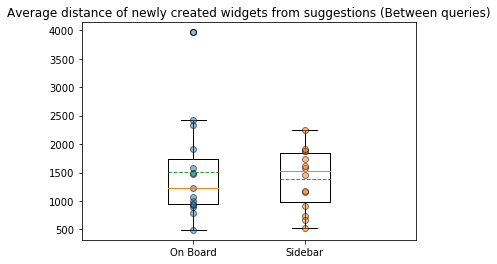

In [53]:
f, ax = plt.subplots()
ax.boxplot(browser_df_joined[browser_df_joined['studyType']=='On Board'].groupby('boardId')['averageDistance'].mean().dropna(),positions=[1/3], showmeans=True, meanline=True)
ax.boxplot(browser_df_joined[browser_df_joined['studyType']=='Sidebar'].groupby('boardId')['averageDistance'].mean().dropna(),positions=[2/3], showmeans=True, meanline=True)
ax.plot([1/3  for x in range(len(browser_df_joined[browser_df_joined['studyType']=='On Board'].groupby('boardId')['averageDistance'].mean()))], browser_df_joined[browser_df_joined['studyType']=='On Board'].groupby('boardId')['averageDistance'].mean(), 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2/3 for x in range(len(browser_df_joined[browser_df_joined['studyType']=='Sidebar'].groupby('boardId')['averageDistance'].mean()))], browser_df_joined[browser_df_joined['studyType']=='Sidebar'].groupby('boardId')['averageDistance'].mean(), 'o', markeredgecolor='k', alpha=0.5)
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
ax.set_title('Average distance of newly created widgets from suggestions (Between queries)')
plt.show()


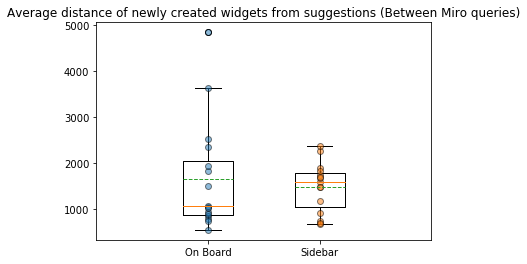

In [54]:
f, ax = plt.subplots()
ax.boxplot(miroQueries_df[miroQueries_df['studyType']=='On Board'].groupby('boardId')['averageDistance'].mean().dropna(),positions=[1/3], showmeans=True, meanline=True)
ax.boxplot(miroQueries_df[miroQueries_df['studyType']=='Sidebar'].groupby('boardId')['averageDistance'].mean().dropna(),positions=[2/3], showmeans=True, meanline=True)
ax.plot([1/3  for x in range(len(miroQueries_df[miroQueries_df['studyType']=='On Board'].groupby('boardId')['averageDistance'].mean()))], miroQueries_df[miroQueries_df['studyType']=='On Board'].groupby('boardId')['averageDistance'].mean(), 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2/3 for x in range(len(miroQueries_df[miroQueries_df['studyType']=='Sidebar'].groupby('boardId')['averageDistance'].mean()))], miroQueries_df[miroQueries_df['studyType']=='Sidebar'].groupby('boardId')['averageDistance'].mean(), 'o', markeredgecolor='k', alpha=0.5)
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
ax.set_title('Average distance of newly created widgets from suggestions (Between Miro queries)')
plt.show()
aggTotalBoard=aggTotalBoard.join(miroQueries_df.groupby('boardId')['averageDistance'].mean().dropna())

### Types of widgets added after querying suggestions

In [55]:
addedWidgets=pd.DataFrame()
for boardId in boardInfo.index:
    widgets=[]
    board_df = create_board_df(boardId)
    for widgetTypes in board_df['widgetTypes']:
        for widgetType in widgetTypes:
            
            widgetGroup = 'Sensemaking Widgets' if widgetType in ['Cluster', 'ClusterTitle', 'LINE'] else 'Information Widgets'
            addedWidgets=addedWidgets.append({'boardId': boardId, 'widgetType': widgetType, 'widgetGroup': widgetGroup}, ignore_index=True)
addedWidgets['count']=1

addedWidgets = addedWidgets.join(boardInfo, on='boardId',how='inner')
addedWidgetsTypes = pd.pivot_table(addedWidgets, values='count', index=['studyType'], columns='widgetGroup', aggfunc='sum', fill_value=0)

            
            

# f, ax = plt.subplots()
# ax.boxplot(browser_df_joined[browser_df_joined['studyType']=='On Board'].groupby('boardId')['totalDistance'].sum(),positions=[1/3])
# ax.boxplot(browser_df_joined[browser_df_joined['studyType']=='Sidebar'].groupby('boardId')['totalDistance'].sum(),positions=[2/3])
# ax.plot([1/3  for x in range(len(browser_df_joined[browser_df_joined['studyType']=='On Board'].groupby('boardId')['totalDistance'].sum()))], browser_df_joined[browser_df_joined['studyType']=='On Board'].groupby('boardId')['totalDistance'].sum(), 'o', markeredgecolor='k', alpha=0.5)
# ax.plot([2/3 for x in range(len(browser_df_joined[browser_df_joined['studyType']=='Sidebar'].groupby('boardId')['totalDistance'].sum()))], browser_df_joined[browser_df_joined['studyType']=='Sidebar'].groupby('boardId')['totalDistance'].sum(), 'o', markeredgecolor='k', alpha=0.5)
# plt.xlim([0, 1])
# ax.set_xticks([1/3, 2/3])
# ax.set_xticklabels(['On Board', 'Sidebar'])
# ax.set_title('Total distance of newly created widgets from suggestions')
# plt.show()

o9J_lth3zkI=
o9J_lth9DEA=
o9J_lthxoK8=
o9J_lthxoSw=
o9J_lwMyp0I=
o9J_lwT0kWk=
o9J_lwT45Gc=
o9J_lwT45UE=
o9J_lwTEkh4=
o9J_lwTEnSI=
o9J_lwTEnZk=
o9J_lwTHmNo=
o9J_lwTHmtQ=
o9J_lwhnitY=
o9J_lwi6_1c=
o9J_lwj9wsM=
o9J_lwt44k0=
o9J_lwtLWiA=
o9J_lwtLWq0=
o9J_lwtLZY8=
o9J_lx2--OQ=
o9J_lxP9EsE=
o9J_lxPFjOs=
o9J_lxTWUZI=
o9J_ly0SnkM=
o9J_ly0Snnk=
o9J_ly0SnuI=
o9J_lyGIeLY=
o9J_lyGIfks=
o9J_lyGIfzA=
o9J_lyYiAJ0=
o9J_lyYiALM=
o9J_lzYgHyw=
o9J_lzYurAk=


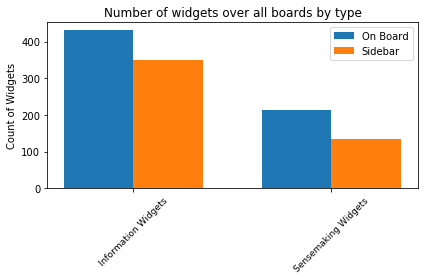

In [56]:
fig, ax = plt.subplots()
x = np.arange(len(addedWidgetsTypes.columns)) 
width = 0.35
addedWidgetsTypesList = addedWidgetsTypes.values.tolist()
rects1 = ax.bar(x - width/2, addedWidgetsTypesList[0], width, label='On Board')
rects2 = ax.bar(x + width/2, addedWidgetsTypesList[1], width, label='Sidebar')
ax.set_ylabel('Count of Widgets')
ax.set_title('Number of widgets over all boards by type')
ax.set_xticks(x)
ax.set_xticklabels(addedWidgetsTypes.columns, rotation=45, size=9)
ax.legend()

fig.tight_layout()
plt.show()

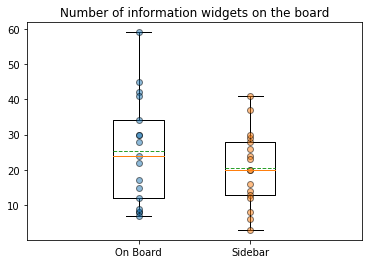

In [57]:
f, ax = plt.subplots()
ax.boxplot(addedWidgets[(addedWidgets['widgetGroup']=='Information Widgets') & (addedWidgets['studyType']=='On Board')].groupby('boardId')['count'].sum(),positions=[1/3], showmeans=True, meanline=True)
ax.boxplot(addedWidgets[(addedWidgets['widgetGroup']=='Information Widgets') & (addedWidgets['studyType']=='Sidebar')].groupby('boardId')['count'].sum(),positions=[2/3], showmeans=True, meanline=True)
ax.plot([1/3  for x in range(len(addedWidgets[(addedWidgets['widgetGroup']=='Information Widgets') & (addedWidgets['studyType']=='On Board')].groupby('boardId')['count'].sum()))], addedWidgets[(addedWidgets['widgetGroup']=='Information Widgets') & (addedWidgets['studyType']=='On Board')].groupby('boardId')['count'].sum(), 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2/3 for x in range(len(addedWidgets[(addedWidgets['widgetGroup']=='Information Widgets') & (addedWidgets['studyType']=='Sidebar')].groupby('boardId')['count'].sum()))], addedWidgets[(addedWidgets['widgetGroup']=='Information Widgets') & (addedWidgets['studyType']=='Sidebar')].groupby('boardId')['count'].sum(), 'o', markeredgecolor='k', alpha=0.5)
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
ax.set_title('Number of information widgets on the board')
plt.show()
aggTotalBoard=aggTotalBoard.join(addedWidgets[addedWidgets['widgetGroup']=='Information Widgets'].groupby('boardId')['count'].sum())
aggTotalBoard=aggTotalBoard.rename(columns={'count': 'Information Widgets'})

In [58]:
aggTotalBoard

,content,wordTotal,widgetCount,studyType,topicTask,suggestionsOffered,suggestionsQueried,queriesNotFromMiro,queriesFromMiro,Cluster,Line,Note,Topic Task,averageDistance,Information Widgets
boardId,,,,,,,,,,,,,,,
o9J_lth3zkI=,"[{'bounds': {'bottom': -56.95547439637653, 'he...",622,34,On Board,Space Travel,13,7.0,4.0,12.0,0.0,0.0,7.0,0.0,929.868295,34
o9J_lth9DEA=,"[{'bounds': {'bottom': 108.36248934295736, 'he...",181,13,Sidebar,Space Travel,6,0.0,2.0,0.0,0.0,0.0,0.0,0.0,NaN,14
o9J_lthxoK8=,"[{'bounds': {'bottom': -64.5, 'height': 303, '...",181,13,Sidebar,COVID-19,7,1.0,7.0,1.0,0.0,0.0,1.0,0.0,1463.426123,13
o9J_lthxoSw=,"[{'bounds': {'bottom': 1044.3195222955671, 'he...",193,26,On Board,COVID-19,14,6.0,12.0,8.0,0.0,0.0,6.0,0.0,540.146920,30
o9J_lwMyp0I=,"[{'bounds': {'bottom': 250, 'height': 500, 'le...",572,27,Sidebar,COVID-19,26,5.0,1.0,5.0,0.0,0.0,4.0,1.0,736.738448,28
o9J_lwT0kWk=,"[{'bounds': {'bottom': -419.0857650827397, 'he...",278,8,On Board,Space Travel,22,5.0,2.0,4.0,0.0,1.0,4.0,0.0,2341.642387,8
o9J_lwT45Gc=,"[{'bounds': {'bottom': 86.58768042961287, 'hei...",272,27,On Board,COVID-19,16,14.0,6.0,18.0,0.0,3.0,11.0,0.0,1039.407505,28
o9J_lwT45UE=,"[{'bounds': {'bottom': -171.79086150615348, 'h...",168,24,Sidebar,COVID-19,12,3.0,3.0,5.0,2.0,0.0,1.0,0.0,2257.548216,26
o9J_lwTEkh4=,"[{'bounds': {'bottom': 106.70499538360457, 'he...",3,3,Sidebar,COVID-19,11,5.0,0.0,5.0,0.0,0.0,5.0,0.0,1744.014473,3


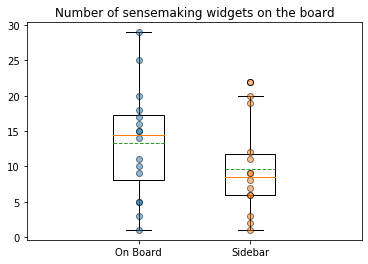

In [59]:
f, ax = plt.subplots()
ax.boxplot(addedWidgets[(addedWidgets['widgetGroup']=='Sensemaking Widgets') & (addedWidgets['studyType']=='On Board')].groupby('boardId')['count'].sum(),positions=[1/3], showmeans=True, meanline=True)
ax.boxplot(addedWidgets[(addedWidgets['widgetGroup']=='Sensemaking Widgets') & (addedWidgets['studyType']=='Sidebar')].groupby('boardId')['count'].sum(),positions=[2/3], showmeans=True, meanline=True)
ax.plot([1/3  for x in range(len(addedWidgets[(addedWidgets['widgetGroup']=='Sensemaking Widgets') & (addedWidgets['studyType']=='On Board')].groupby('boardId')['count'].sum()))], addedWidgets[(addedWidgets['widgetGroup']=='Sensemaking Widgets') & (addedWidgets['studyType']=='On Board')].groupby('boardId')['count'].sum(), 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2/3 for x in range(len(addedWidgets[(addedWidgets['widgetGroup']=='Sensemaking Widgets') & (addedWidgets['studyType']=='Sidebar')].groupby('boardId')['count'].sum()))], addedWidgets[(addedWidgets['widgetGroup']=='Sensemaking Widgets') & (addedWidgets['studyType']=='Sidebar')].groupby('boardId')['count'].sum(), 'o', markeredgecolor='k', alpha=0.5)
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
ax.set_title('Number of sensemaking widgets on the board')
plt.show()
aggTotalBoard=aggTotalBoard.join(addedWidgets[addedWidgets['widgetGroup']=='Sensemaking Widgets'].groupby('boardId')['count'].sum())
aggTotalBoard=aggTotalBoard.rename(columns={'count': 'Sensemaking Widgets'})

o9J_lth3zkI=


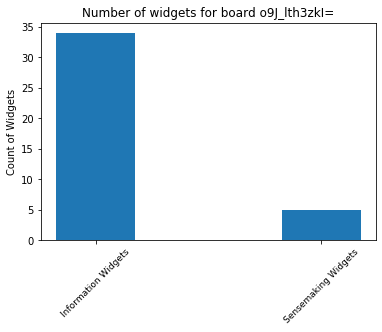

o9J_lthxoSw=


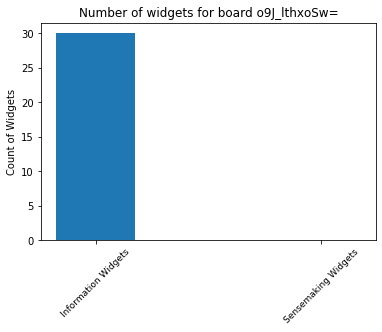

o9J_lwT0kWk=


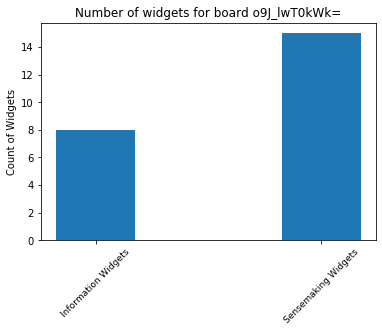

o9J_lwT45Gc=


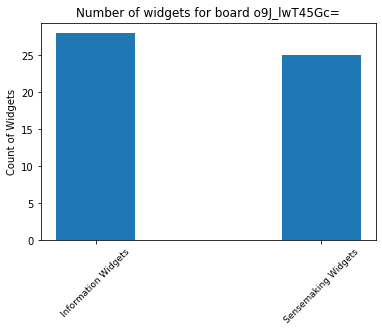

o9J_lwTEnSI=


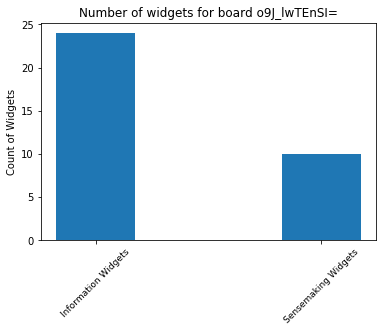

o9J_lwi6_1c=


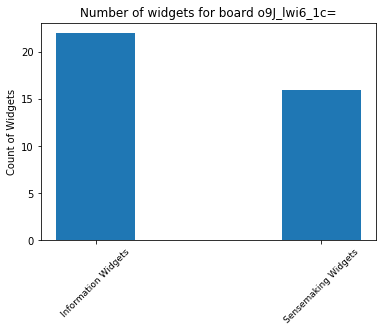

o9J_lwj9wsM=


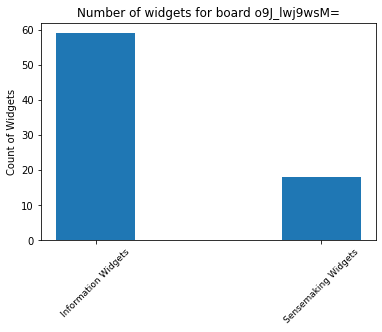

o9J_lwt44k0=


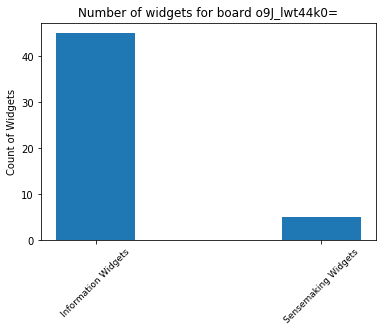

o9J_lwtLWq0=


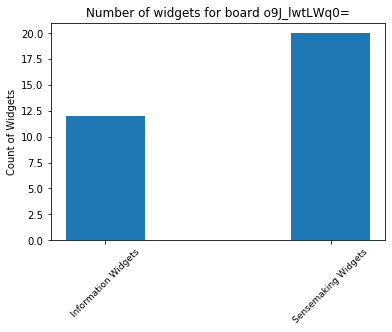

o9J_lwtLZY8=


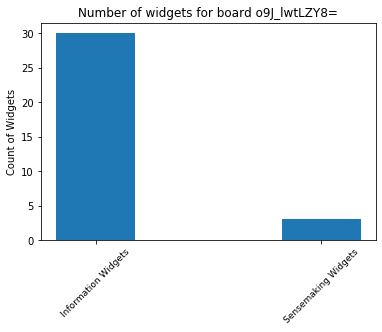

o9J_lx2--OQ=


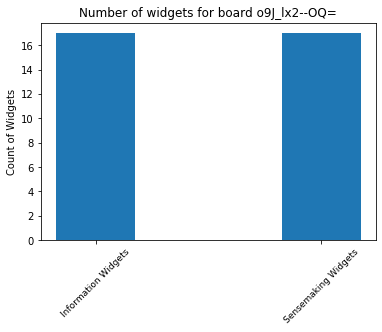

o9J_lxPFjOs=


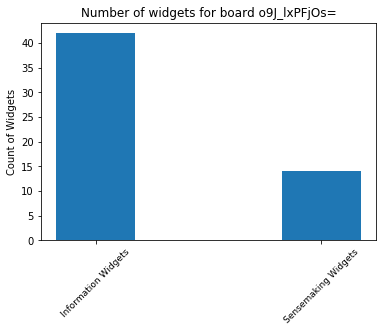

o9J_lxTWUZI=


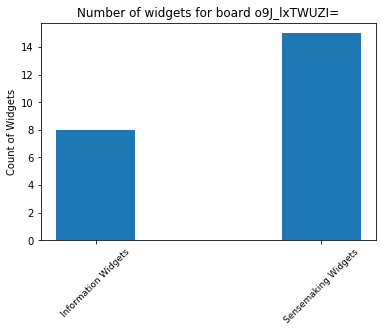

o9J_ly0SnuI=


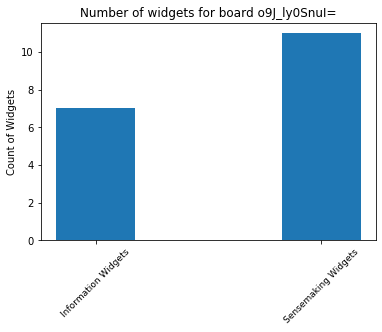

o9J_lyGIeLY=


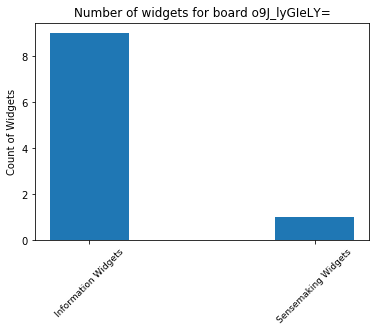

o9J_lyYiALM=


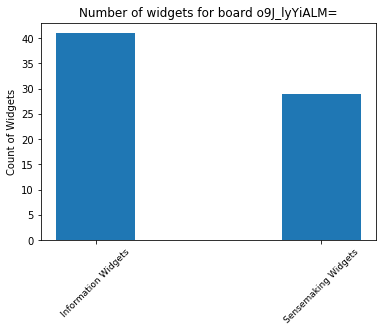

o9J_lzYurAk=


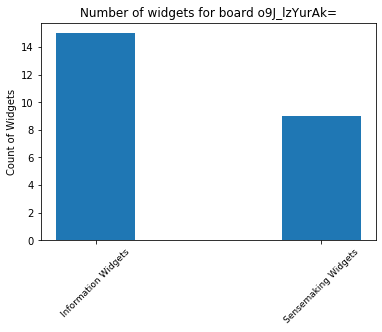

In [60]:
for boardId in onboardBoards.index.unique():
    f, ax = plt.subplots()
    infoWidgets = addedWidgets[(addedWidgets['widgetGroup']=='Information Widgets') & (addedWidgets['boardId']==boardId)].groupby('boardId')['count'].sum()
    senseWidgets = addedWidgets[(addedWidgets['widgetGroup']=='Sensemaking Widgets') & (addedWidgets['boardId']==boardId)].groupby('boardId')['count'].sum()
    print(boardId)
    rects = ax.bar([0, 1], [infoWidgets.iloc[0] if len(infoWidgets)!=0 else 0, senseWidgets.iloc[0] if len(senseWidgets)!=0 else 0], width, label='Information Widgets')
    #rects2 = ax.bar(1, senseWidgets, width, label='Sensemaking Widgets')
    ax.set_ylabel('Count of Widgets')
    ax.set_title('Number of widgets for board ' + boardId)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Information Widgets', 'Sensemaking Widgets'], rotation=45, size=9)

    plt.show()
    

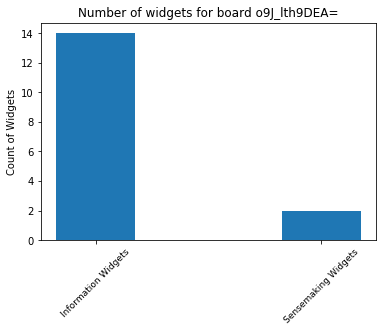

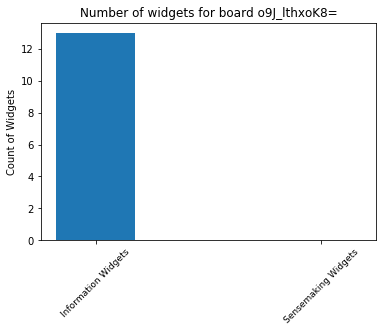

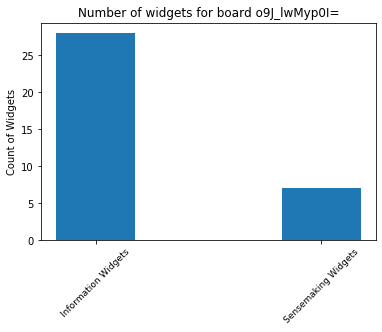

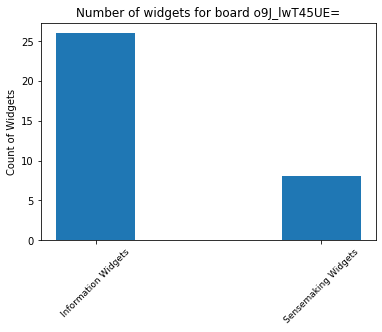

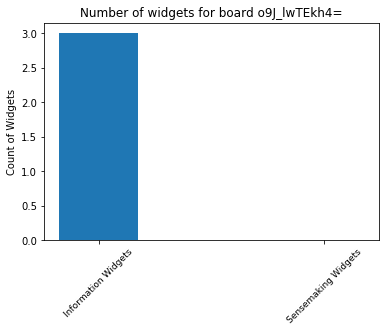

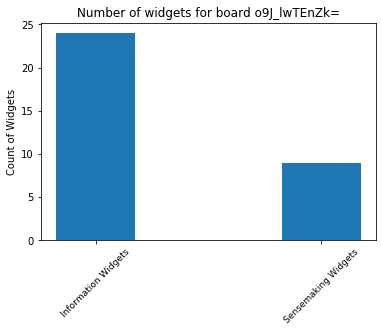

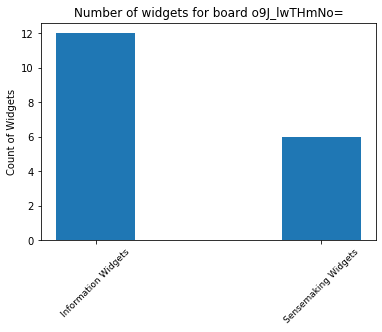

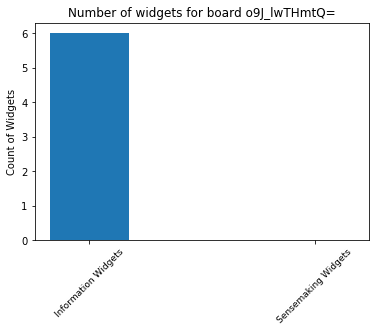

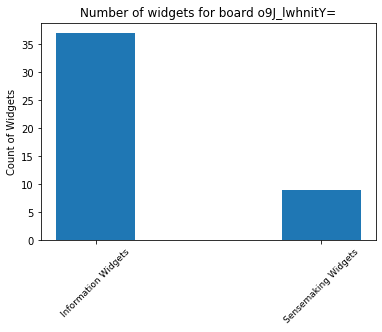

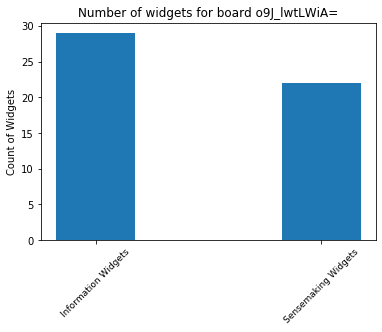

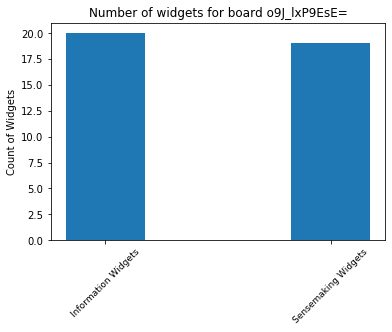

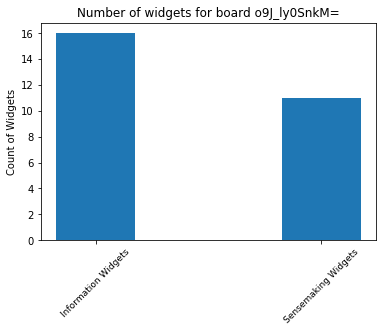

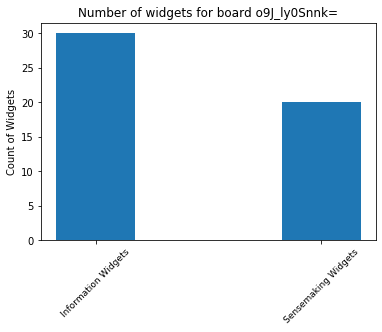

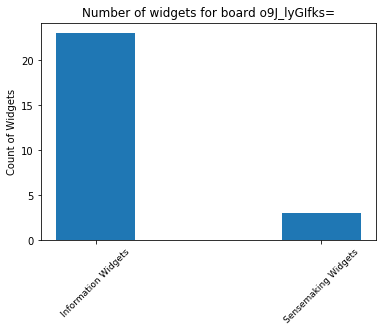

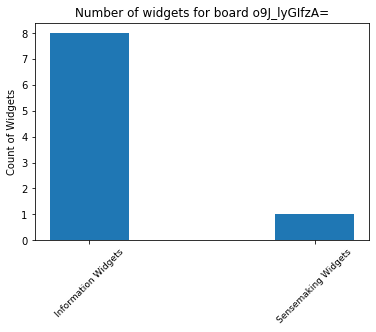

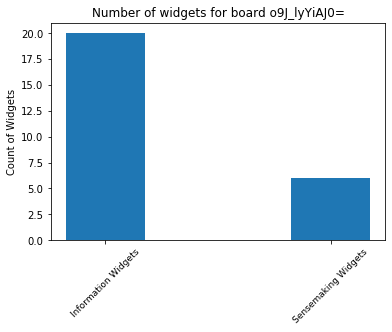

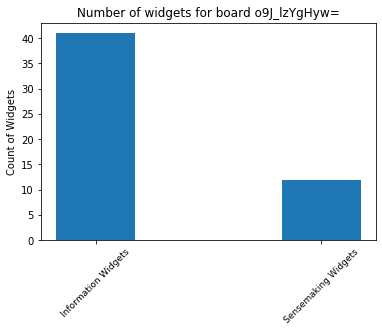

In [61]:
for boardId in sidebarBoards.index.unique():
    f, ax = plt.subplots()
    infoWidgets = addedWidgets[(addedWidgets['widgetGroup']=='Information Widgets') & (addedWidgets['boardId']==boardId)].groupby('boardId')['count'].sum()
    senseWidgets = addedWidgets[(addedWidgets['widgetGroup']=='Sensemaking Widgets') & (addedWidgets['boardId']==boardId)].groupby('boardId')['count'].sum()
    #print(infoWidgets, senseWidgets)
    if len(infoWidgets)==0 and len(senseWidgets)==0:
        rects = ax.bar([0, 1], [0 , 0], width, label='Information Widgets')
    elif len(infoWidgets)==0:
        rects = ax.bar([0, 1], [0, senseWidgets.iloc[0]], width, label='Information Widgets')
    elif len(senseWidgets)==0:
        rects = ax.bar([0, 1], [infoWidgets.iloc[0], 0], width, label='Information Widgets')
    else:
        rects = ax.bar([0, 1], [infoWidgets.iloc[0], senseWidgets.iloc[0]], width, label='Information Widgets')
    #rects2 = ax.bar(1, senseWidgets, width, label='Sensemaking Widgets')
    ax.set_ylabel('Count of Widgets')
    ax.set_title('Number of widgets for board ' + boardId)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Information Widgets', 'Sensemaking Widgets'], rotation=45, size=9)

    plt.show()

## Quantity of Sensemaking

### Focus

In [62]:
clusterDf =pd.DataFrame()

for key, item in presentBoards.iterrows():
    widgets = list(eval(item['content']))
    #print(type(widgets))
    for widget in widgets:
        if 'metadata' in widget and client_id in widget['metadata']:
            widgetType = widget['metadata'][client_id]['type']
        elif 'metadata' in widget and client_id2 in widget['metadata']:
            widgetType = widget['metadata'][client_id2]['type']
        else:
            widgetType=widget['type']
        if widgetType=='Cluster':
            clusterDf=clusterDf.append({'boardId': item['boardId'], 'bounds': widget['bounds'], 'studyType': item['studyType']}, ignore_index=True)
            
widgetsWithinClusters = pd.DataFrame()

for key, item in presentBoards.iterrows():
    widgets = list(eval(item['content']))
    #print(type(widgets))
    clusterWidgets=0
    for widget in widgets:
        if 'metadata' in widget and client_id in widget['metadata']:
            widgetType = widget['metadata'][client_id]['type']
        elif 'metadata' in widget and client_id2 in widget['metadata']:
            widgetType = widget['metadata'][client_id2]['type']
        else:
            widgetType=widget['type']
        text = widget['plainText'] if 'plainText' in widget else ''
        if widgetType not in ['Cluster', 'ClusterTitle', 'LINE', 'Line']:
            if '🔎︎' not in text and '✗' not in text:
                for clusterKey, clusterItem in clusterDf[clusterDf['boardId']==item['boardId']].iterrows():
                    if widget['x']<=clusterItem.bounds['right'] and widget['x']>=clusterItem.bounds['left'] and widget['y'] >= clusterItem.bounds['top'] and widget['y']<=clusterItem.bounds['bottom']:
                        widgetsWithinClusters=widgetsWithinClusters.append({'boardId': item['boardId'], 'clusterKey': clusterKey, 'text': text, 'type': widgetType, 'studyType': item['studyType'], 'words': len(text.split())}, ignore_index=True)
        else:
            if widgetType!='Line':
                clusterWidgets+=1
    presentBoards.at[key, 'clusterWidgets']=clusterWidgets

In [63]:
clusterWidgetsTotals=widgetsWithinClusters[widgetsWithinClusters['type'].isin(['TEXT', 'STICKER', 'SHAPE'])].groupby('clusterKey')['type'].count()
clusterDf['clusterWidgetsTotals']=clusterWidgetsTotals
clusterWordTotals=widgetsWithinClusters.groupby('clusterKey')['words'].sum()
clusterDf['clusterWordTotals']=clusterWordTotals
clusterDf = clusterDf.fillna(0)
clusterDf

,boardId,bounds,studyType,clusterWidgetsTotals,clusterWordTotals
0,o9J_lwMyp0I=,"{'bottom': 1342.818930648536, 'height': 717.31...",Sidebar,6.0,151.0
1,o9J_lwMyp0I=,"{'bottom': 1423.023725688912, 'height': 797.52...",Sidebar,8.0,151.0
2,o9J_lwMyp0I=,"{'bottom': 2758.8997008671126, 'height': 478.2...",Sidebar,1.0,102.0
3,o9J_lwMyp0I=,"{'bottom': 2220.544241544113, 'height': 797.52...",Sidebar,4.0,97.0
4,o9J_lwT0kWk=,"{'bottom': -65.90597671754381, 'height': 440.7...",On Board,0.0,0.0
...,...,...,...,...,...
113,o9J_lzYgHyw=,"{'bottom': 242.7128455309964, 'height': 200, '...",Sidebar,1.0,2.0
114,o9J_lzYgHyw=,"{'bottom': 242.7128455309964, 'height': 200, '...",Sidebar,1.0,2.0
115,o9J_lzYgHyw=,"{'bottom': 242.7128455309964, 'height': 200, '...",Sidebar,1.0,2.0
116,o9J_lzYurAk=,"{'bottom': 3212.03521006682, 'height': 2469.19...",On Board,2.0,8.0


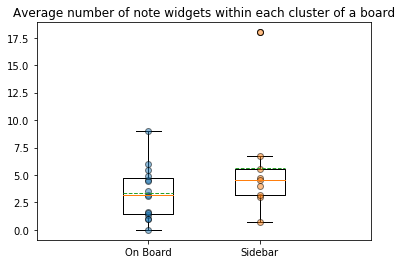

In [64]:
f, ax = plt.subplots()
ax.boxplot(clusterDf[(clusterDf['studyType']=='On Board')].groupby('boardId')['clusterWidgetsTotals'].mean(),positions=[1/3], showmeans=True, meanline=True)
ax.boxplot(clusterDf[(clusterDf['studyType']=='Sidebar')].groupby('boardId')['clusterWidgetsTotals'].mean(),positions=[2/3], showmeans=True, meanline=True)
ax.plot([1/3  for x in range(len(clusterDf[(clusterDf['studyType']=='On Board')].groupby('boardId')['clusterWidgetsTotals'].mean()))], clusterDf[(clusterDf['studyType']=='On Board')].groupby('boardId')['clusterWidgetsTotals'].mean(), 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2/3 for x in range(len(clusterDf[(clusterDf['studyType']=='Sidebar')].groupby('boardId')['clusterWidgetsTotals'].mean()))], clusterDf[(clusterDf['studyType']=='Sidebar')].groupby('boardId')['clusterWidgetsTotals'].mean(), 'o', markeredgecolor='k', alpha=0.5)
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
ax.set_title('Average number of note widgets within each cluster of a board')
plt.show()
aggTotalBoard=aggTotalBoard.join(clusterDf.groupby('boardId')['clusterWidgetsTotals'].mean())

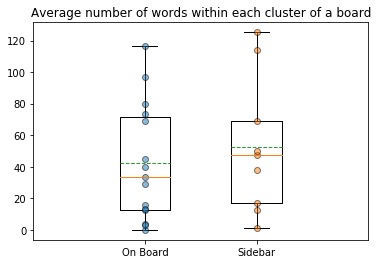

In [65]:
f, ax = plt.subplots()
ax.boxplot(clusterDf[(clusterDf['studyType']=='On Board')].groupby('boardId')['clusterWordTotals'].mean(),positions=[1/3], showmeans=True, meanline=True)
ax.boxplot(clusterDf[(clusterDf['studyType']=='Sidebar')].groupby('boardId')['clusterWordTotals'].mean(),positions=[2/3], showmeans=True, meanline=True)
ax.plot([1/3  for x in range(len(clusterDf[(clusterDf['studyType']=='On Board')].groupby('boardId')['clusterWordTotals'].mean()))], clusterDf[(clusterDf['studyType']=='On Board')].groupby('boardId')['clusterWordTotals'].mean(), 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2/3 for x in range(len(clusterDf[(clusterDf['studyType']=='Sidebar')].groupby('boardId')['clusterWordTotals'].mean()))], clusterDf[(clusterDf['studyType']=='Sidebar')].groupby('boardId')['clusterWordTotals'].mean(), 'o', markeredgecolor='k', alpha=0.5)
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
ax.set_title('Average number of words within each cluster of a board')
plt.show()
aggTotalBoard=aggTotalBoard.join(clusterDf.groupby('boardId')['clusterWordTotals'].mean())

### Entropy/Branchiness

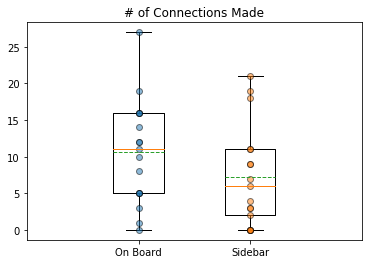

In [66]:
f, ax = plt.subplots()
ax.boxplot(presentBoards[(presentBoards['studyType']=='On Board')]['clusterWidgets'],positions=[1/3], showmeans=True, meanline=True)
ax.boxplot(presentBoards[(presentBoards['studyType']=='Sidebar')]['clusterWidgets'],positions=[2/3], showmeans=True, meanline=True)
ax.plot([1/3  for x in range(len(presentBoards[(presentBoards['studyType']=='On Board')]['clusterWidgets']))], presentBoards[(presentBoards['studyType']=='On Board')]['clusterWidgets'], 'o', markeredgecolor='k', alpha=0.5)
ax.plot([2/3 for x in range(len(presentBoards[(presentBoards['studyType']=='Sidebar')]['clusterWidgets']))], presentBoards[(presentBoards['studyType']=='Sidebar')]['clusterWidgets'], 'o', markeredgecolor='k', alpha=0.5)
plt.xlim([0, 1])
ax.set_xticks([1/3, 2/3])
ax.set_xticklabels(['On Board', 'Sidebar'])
ax.set_title('# of Connections Made')
plt.show()
aggTotalBoard=presentBoards[['boardId','clusterWidgets']].join(aggTotalBoard, on='boardId')

In [67]:
aggTotalBoard.to_csv('aggTotals.csv')